# Project Overview

### Medical Insurance Cost Analysis and Prediction
In recent years, healthcare costs have been rising globally, leading to growing interest in methods for understanding and predicting medical insurance expenses. Research has shown that demographic factors such as age, gender, BMI, and smoking habits play a substantial role in determining health risks and insurance costs. This project applies machine learning techniques to analyse personal and demographic data, including variables such as the number of children and geographic location, to identify the key factors influencing insurance pricing. By identifying patterns and building predictive models, this study aims to help insurers improve their risk assessments and develop more personalised and fairer policies.

Machine learning models have already proven effective in a variety of healthcare applications, from diagnosing diseases to optimising operational efficiency. Similarly, this project demonstrates how predictive algorithms can support fairer insurance pricing strategies, benefiting both providers and customers. The dataset used for this analysis is sourced from publicly available data, ensuring that the findings are based on broadly accessible information.

### Stakeholders
The key stakeholders for this project are:
1. Insurance Companies
   - Actuaries who are responsible for assessing risks and calculating premiums.
   - Policy designers who seek to create personalised insurance plans.
   - Claims departments that benefit from accurate cost predictions.

2. Healthcare Providers
   - Hospital Administrators interested in financial planning
   - Healthcare Management focused on fair service pricing
   - Medical Practitioner aiming to understand the cost implications

3. Customers/Patients
   - Potential Insurance Buyer who want to understand cost factors
   - Current Policyholders for managing health-related costs
   - Families planning their finances and evaluating insurance options.


## Research Questions:

1. Cost Factors Analysis
   - How significantly does smoking status impact insurance charges?
   - What is the relationship between BMI and insurance costs?
   - How does age correlate with insurance charges?

2. Demographic Impact
   - Are there significant regional variations in insurance costs?
   - How does family size (number of children) affect insurance charges?
   - Is there a gender disparity in insurance costs?

3. Risk Assessment
   - What combination of factors leads to highest insurance charges?
   - Can we identify high-risk profiles based on available features?
   - How do multiple risk factors interact to affect costs?

4. Predictive Modeling
   - Which machine learning model best predicts insurance charges?
   - What are the most influential features in predicting costs?
   - How reliable are our predictions across different demographic groups?


# Libraries and Dependencies

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import joblib
from scipy.special import boxcox1p
from scipy.stats import ttest_rel
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor,
    VotingRegressor,
    AdaBoostRegressor
)
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    KFold,
    learning_curve
)
from sklearn.base import clone
from scipy import stats
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    make_scorer,
    mean_absolute_error,
    explained_variance_score
)
import warnings
warnings.filterwarnings('ignore')

# Constants Variables

In [2]:
class Config:
    
    # File paths
    DATA_PATH = 'insurance-adapted.csv'
    OUTPUT_PATH = 'models/'
    
    # Random state for reproducibility
    RANDOM_STATE = 42
    
    # Data split parameters
    TEST_SIZE = 0.2
    VALIDATION_SIZE = 0.2
    
    # Cross-validation settings
    N_FOLDS = 5
    
    # Feature categories
    NUMERIC_FEATURES = ['age', 'bmi', 'children']
    CATEGORICAL_FEATURES = ['sex', 'smoker', 'region']
    TARGET = 'charges'
    
    # Feature groups for analysis
    FEATURE_GROUPS = {
        'personal': ['age', 'sex', 'bmi'],
        'lifestyle': ['smoker'],
        'family': ['children'],
        'location': ['region'],
        'target': ['charges']
    }
    
    # Threshold values for feature binning
    AGE_BINS = [0, 25, 35, 45, 55, 65, 100]
    AGE_LABELS = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
    
    BMI_BINS = [0, 18.5, 24.9, 29.9, 100]
    BMI_LABELS = ['Underweight', 'Normal', 'Overweight', 'Obese']
    
    # Visualization settings
    FIGSIZE = (12, 8)
    STYLE = 'seaborn'
    COLOR_PALETTE = 'viridis'
    
    # Analysis parameters
    CORRELATION_THRESHOLD = 0.7
    OUTLIER_THRESHOLD = 1.5  # For IQR method
    
    # Risk assessment parameters
    RISK_WEIGHTS = {
        'age': 0.2,
        'bmi': 0.3,
        'smoker': 0.35,
        'children': 0.15
    }

# Utils

In [3]:
class Utils:
    """Utility functions for data analysis"""
    
    @staticmethod
    def load_and_validate_data(path):
        """
        Load data and perform initial validation checks with proper error handling
        
        Parameters:
        -----------
        path : str
            Path to the data file
            
        Returns:
        --------
        pd.DataFrame
            Validated dataframe
        """
        try:
            # Load data
            df = pd.read_csv(path)
            print(f"Successfully loaded data from {path}")
            print(f"Dataset shape: {df.shape}")
            
            # Handle data type conversions
            df_cleaned = df.copy()
            
            # Clean and convert numeric columns
            numeric_columns = {
                'age': 'float64',  
                'children': 'float64',  
                'bmi': 'float64',
                'charges': 'float64'
            }
            
            for col, dtype in numeric_columns.items():
                if col in df_cleaned.columns:
                    # Replace any non-finite values with NaN
                    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
                    
                    # Check for NaN values
                    nan_count = df_cleaned[col].isna().sum()
                    if nan_count > 0:
                        print(f"Warning: Found {nan_count} missing/invalid values in {col}")
                    
                    if col in ['age', 'children'] and nan_count == 0:
                        df_cleaned[col] = df_cleaned[col].astype('int64')
            
            # Validate categorical columns
            categorical_columns = ['sex', 'smoker', 'region']
            for col in categorical_columns:
                if col in df_cleaned.columns:
                    unique_values = df_cleaned[col].unique()
                    print(f"\nUnique values in {col}: {unique_values}")
            
            print("\nData types after cleaning:")
            print(df_cleaned.dtypes)
            
            return df_cleaned
            
        except Exception as e:
            print(f"Error loading data: {e}")
            return None
    
    @staticmethod
    def check_data_quality(df):
        """
        Perform data quality checks
        
        Parameters:
        -----------
        df : pd.DataFrame
            Input dataframe
            
        Returns:
        --------
        dict
            Dictionary containing data quality metrics
        """
        quality_metrics = {}
        
        # Check missing values
        missing_values = df.isnull().sum()
        quality_metrics['missing_values'] = missing_values[missing_values > 0]
        
        # Check duplicates
        quality_metrics['duplicates'] = df.duplicated().sum()
        
        # Check value ranges
        numeric_ranges = {}
        for col in ['age', 'bmi', 'children', 'charges']:
            numeric_ranges[col] = {
                'min': df[col].min(),
                'max': df[col].max(),
                'mean': df[col].mean(),
                'median': df[col].median(),
                'null_count': df[col].isnull().sum(),
                'unique_count': df[col].nunique()
            }
        quality_metrics['numeric_ranges'] = numeric_ranges
        
        # Check categorical values
        categorical_counts = {}
        for col in ['sex', 'smoker', 'region']:
            categorical_counts[col] = {
                'value_counts': df[col].value_counts().to_dict(),
                'null_count': df[col].isnull().sum(),
                'unique_count': df[col].nunique()
            }
        quality_metrics['categorical_counts'] = categorical_counts
        
        return quality_metrics
    
    @staticmethod
    def print_data_summary(df):
        """
        Print data summary
        """
        print("\n=== Data Summary ===")
        print("\nDataset Overview:")
        print("-" * 50)
        print(f"Number of records: {len(df)}")
        print(f"Number of features: {len(df.columns)}")
        
        print("\nFeature Information:")
        print("-" * 50)
        for col in df.columns:
            print(f"\n{col}:")
            print(f"Type: {df[col].dtype}")
            null_count = df[col].isnull().sum()
            print(f"Missing values: {null_count}")
            
            if df[col].dtype in ['int64', 'float64']:
                print(f"Range: {df[col].min()} to {df[col].max()}")
                print(f"Mean: {df[col].mean():.2f}")
                print(f"Median: {df[col].median():.2f}")
                print(f"Standard deviation: {df[col].std():.2f}")
            else:
                print("Unique values:", df[col].nunique())
                print("Value counts:")
                print(df[col].value_counts())
    
    @staticmethod
    def validate_feature_ranges(df):
        """
        Validate feature ranges and check for suspicious values
        """
        validation_results = {
            'age': {
                'valid_range': (0, 100),
                'suspicious_values': df[~df['age'].between(0, 100)]['age'].unique()
            },
            'bmi': {
                'valid_range': (10, 50),
                'suspicious_values': df[~df['bmi'].between(10, 50)]['bmi'].unique()
            },
            'children': {
                'valid_range': (0, 10),
                'suspicious_values': df[~df['children'].between(0, 10)]['children'].unique()
            },
            'charges': {
                'valid_range': (0, 1000000),
                'suspicious_values': df[~df['charges'].between(0, 1000000)]['charges'].unique()
            }
        }
        
        return validation_results

# Data Loading
**Ethical Consideration** - Since insurance datasets are publicly available, it is crucial to use them in a manner that respects the intent behind their availability and ensures the protection of individuals' privacy rights. While informed consent is not required for public data, sensitive attributes such as age, smoking status, and charges must be handled with care to prevent misuse. Anonymisation and data minimisation are essential practices for safeguarding Personally Identifiable Information (PII) and ensuring compliance with the General Data Protection Regulation (GDPR) (European Union, 2016). Biases in data collection, such as the underrepresentation of certain groups, can lead to unfair premium predictions. Therefore, it is vital that the dataset accurately represents diverse groups to avoid discrimination (Angwin et al., 2016).

### The Goal
Our primary objective in this section is to load and validate the insurance dataset performing a initial quality checks to ensure data integrity. We aim to establish a solid foundation for our analysis by understanding the basic structure of our data, identifying any immediate issues such as missing values or duplicates and confirming the data types and ranges of our variables are appropriate for analysis.

In [4]:
print("=== Data Loading and Initial Processing ===")
# Load data
df = Utils.load_and_validate_data(Config.DATA_PATH)
if df is not None:
        # Check data quality
        quality_metrics = Utils.check_data_quality(df)
        print("\nData Quality Metrics:")
        print(quality_metrics)
        
        # Print data summary
        Utils.print_data_summary(df)

=== Data Loading and Initial Processing ===
Successfully loaded data from insurance-adapted.csv
Dataset shape: (1338, 7)

Unique values in sex: ['female' 'male']

Unique values in smoker: ['yes' 'no']

Unique values in region: ['southwest' 'southeast' 'northwest' 'northeast']

Data types after cleaning:
age         float64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Data Quality Metrics:
{'missing_values': age    20
dtype: int64, 'duplicates': 1, 'numeric_ranges': {'age': {'min': 18.0, 'max': 64.0, 'mean': 39.216236722306526, 'median': 39.0, 'null_count': 20, 'unique_count': 47}, 'bmi': {'min': 15.96, 'max': 53.13, 'mean': 30.66339686098655, 'median': 30.4, 'null_count': 0, 'unique_count': 548}, 'children': {'min': 0, 'max': 5, 'mean': 1.0949177877429, 'median': 1.0, 'null_count': 0, 'unique_count': 6}, 'charges': {'min': 1121.8739, 'max': 63770.42801, 'mean': 13270.422265141257, 'median': 9382.0

In [5]:
# Handle missing values in age
print("\nHandling missing values in age column...")
# Fill missing age values with median age grouped by sex and region
df['age'] = df.groupby(['sex', 'region'])['age'].transform(lambda x: x.fillna(x.median()))

# Verify no remaining missing values
missing_after = df.isnull().sum()
print("\nMissing values after handling:")
print(missing_after[missing_after > 0] if missing_after.sum() > 0 else "No missing values remaining")


Handling missing values in age column...

Missing values after handling:
No missing values remaining


### The Outcome
Our dataset has 1338 records with 7 features. Initial validation revealed 20 missing values in the age column and one duplicate record. The dataset showed promising characteristics for analysis with a good distribution of demographic factors: balanced gender representation (50.5% male, 49.5% female), clear smoking status indication (20.5% smokers) and even regional distribution across four geographic areas. Numeric variables showed reasonable ranges with age spanning 18-64 years, BMI from 15.96 to 53.13, and charges from 1,121 to 63,770. The missing age values were successfully handled using median imputation grouped by sex and region resulting in a complete dataset ready for further analysis.

# Exploratory Data Analysis (EDA)

### The Goal
In this phase, we aim to deeply understand the relationships within our data through comprehensive univariate, bivariate, and multivariate analysis. Our focus is on uncovering patterns in insurance charges across different demographic groups, identifying potential correlations between variables and understanding the distribution of key features that might influence insurance costs. This exploration will guide our feature engineering and model selection decisions.


=== Exploratory Data Analysis ===

Performing Univariate Analysis...


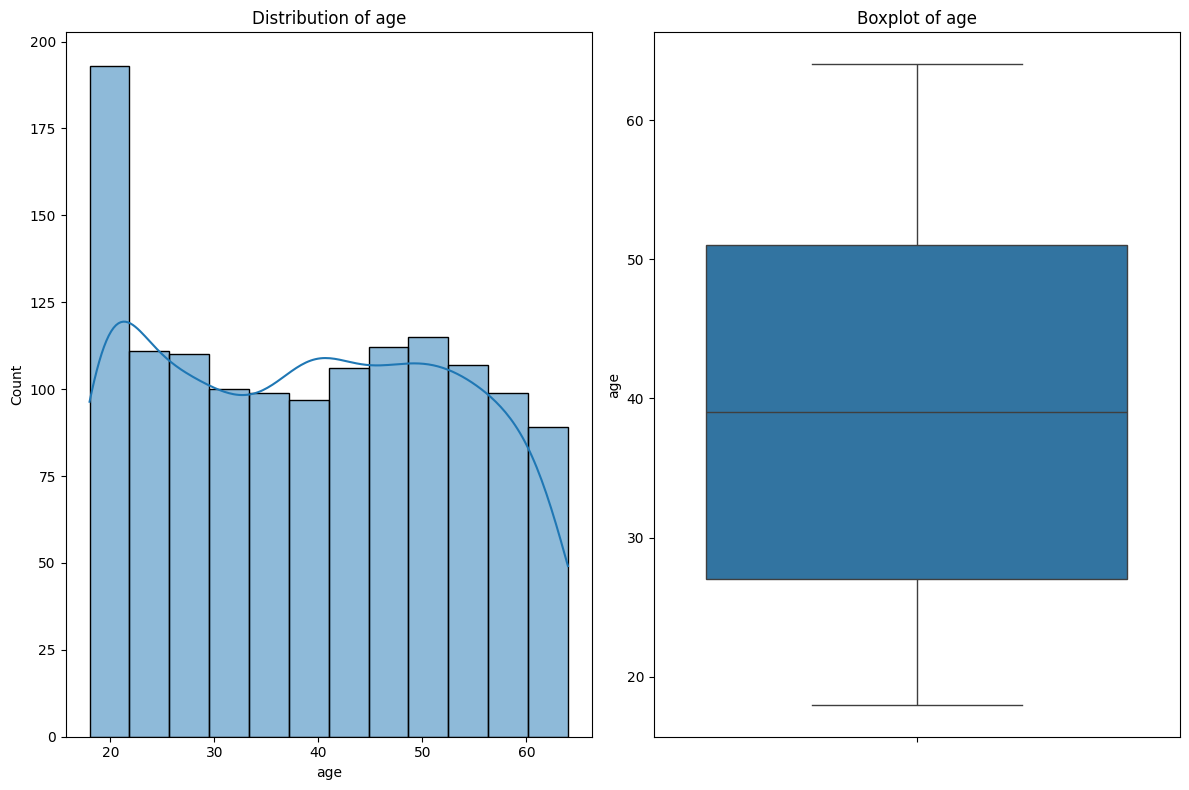


Summary Statistics for age:
mean        39.218
median      39.000
std         13.978
skew         0.053
kurtosis    -1.225
iqr         24.000
dtype: float64


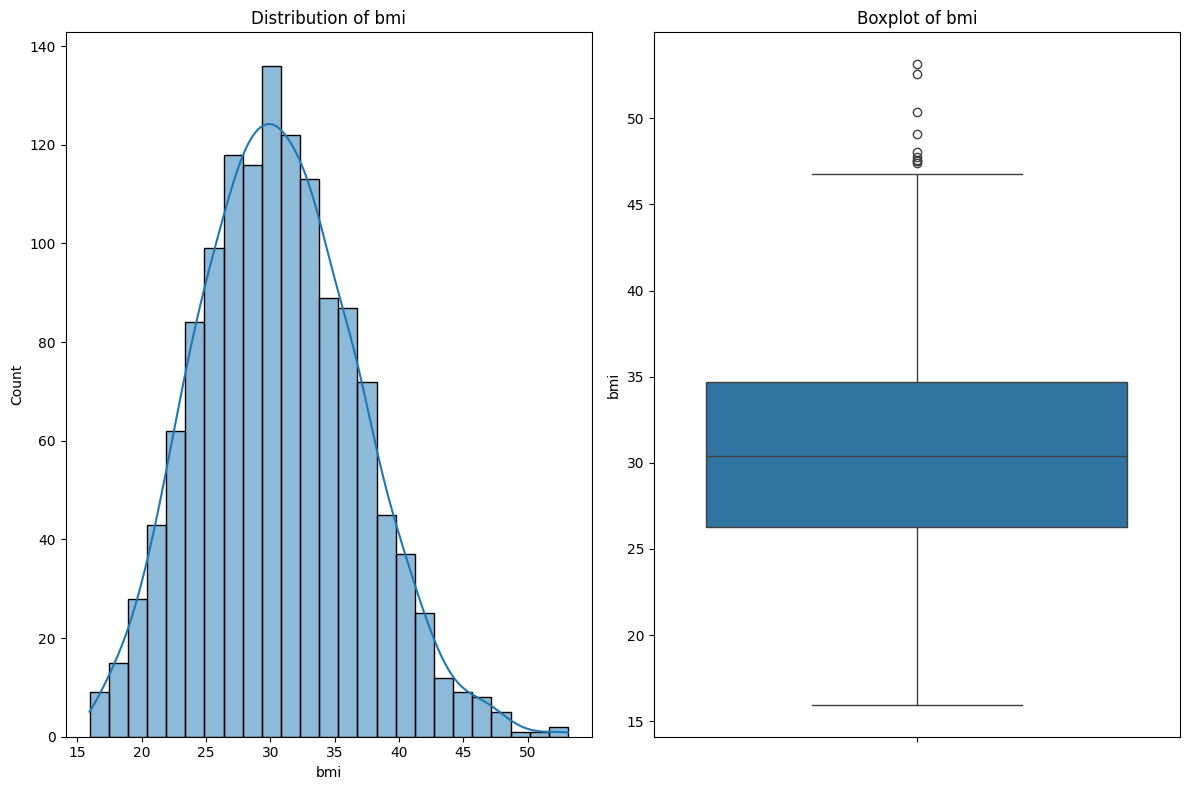


Summary Statistics for bmi:
mean        30.663
median      30.400
std          6.098
skew         0.284
kurtosis    -0.051
iqr          8.398
dtype: float64


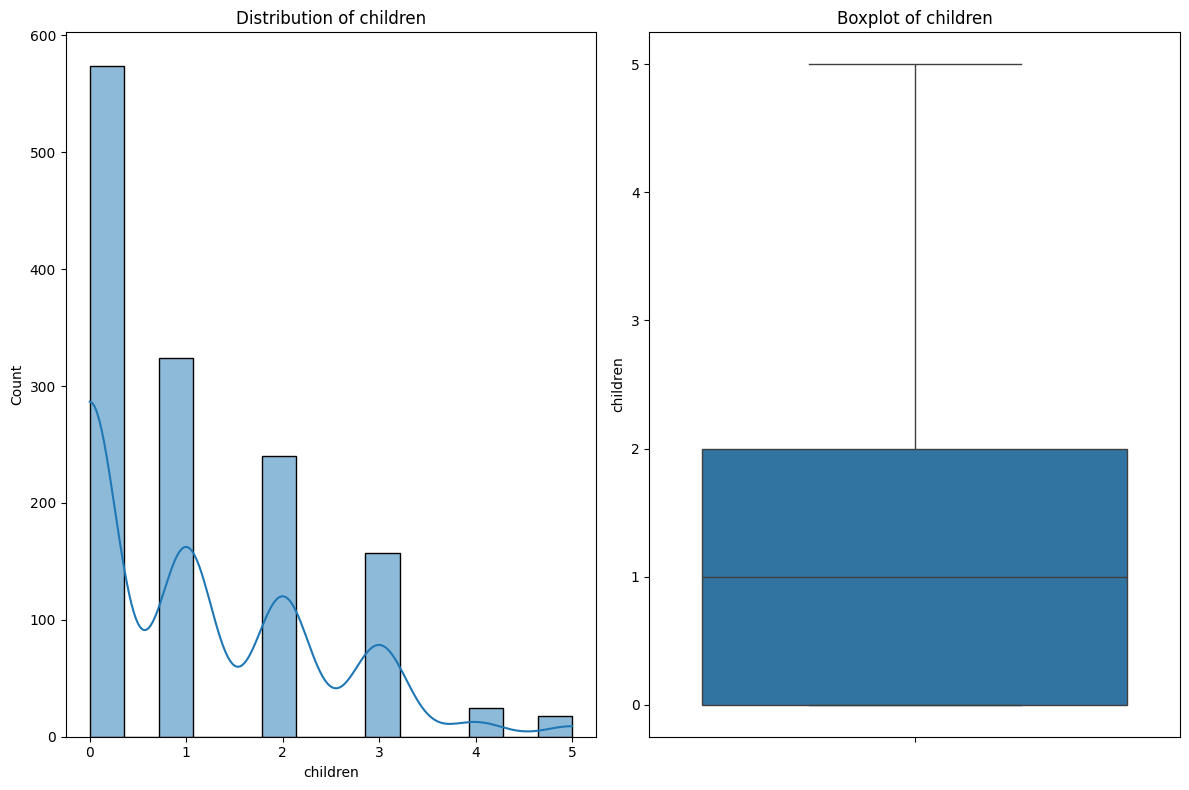


Summary Statistics for children:
mean        1.095
median      1.000
std         1.205
skew        0.938
kurtosis    0.202
iqr         2.000
dtype: float64


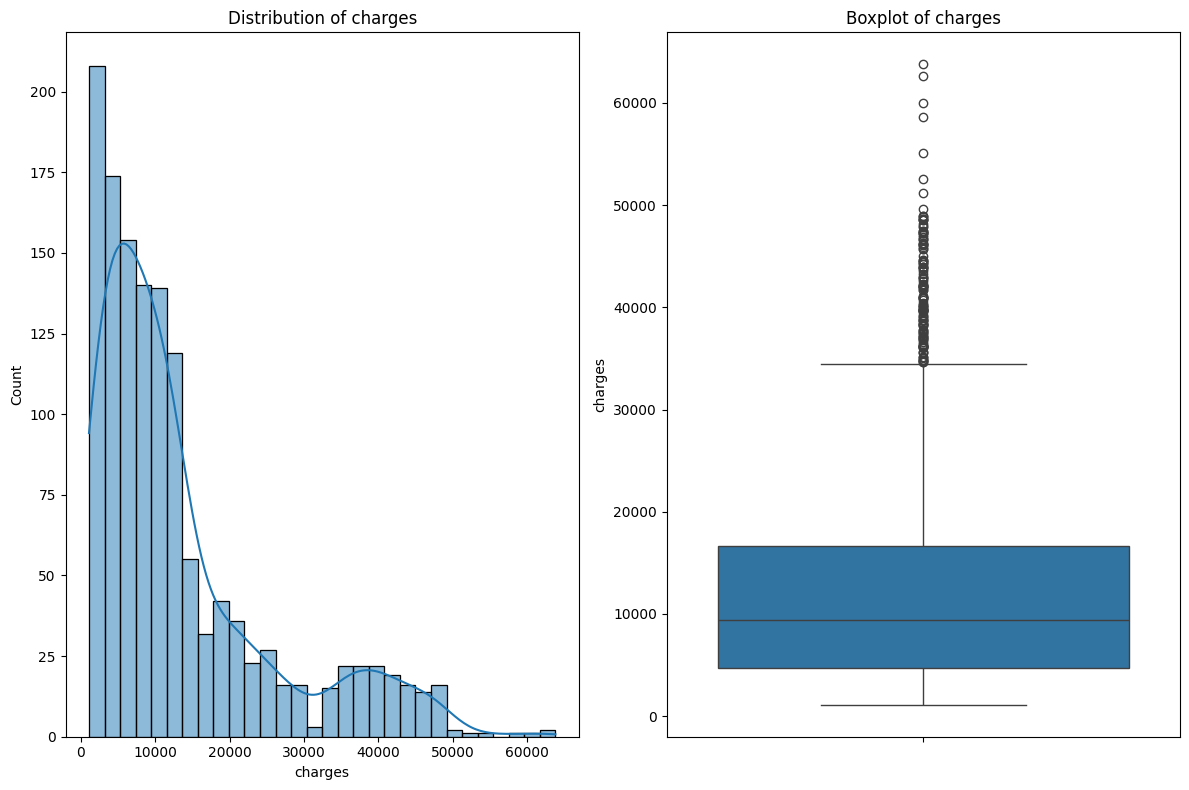


Summary Statistics for charges:
mean        13270.422
median       9382.033
std         12110.011
skew            1.516
kurtosis        1.606
iqr         11899.625
dtype: float64


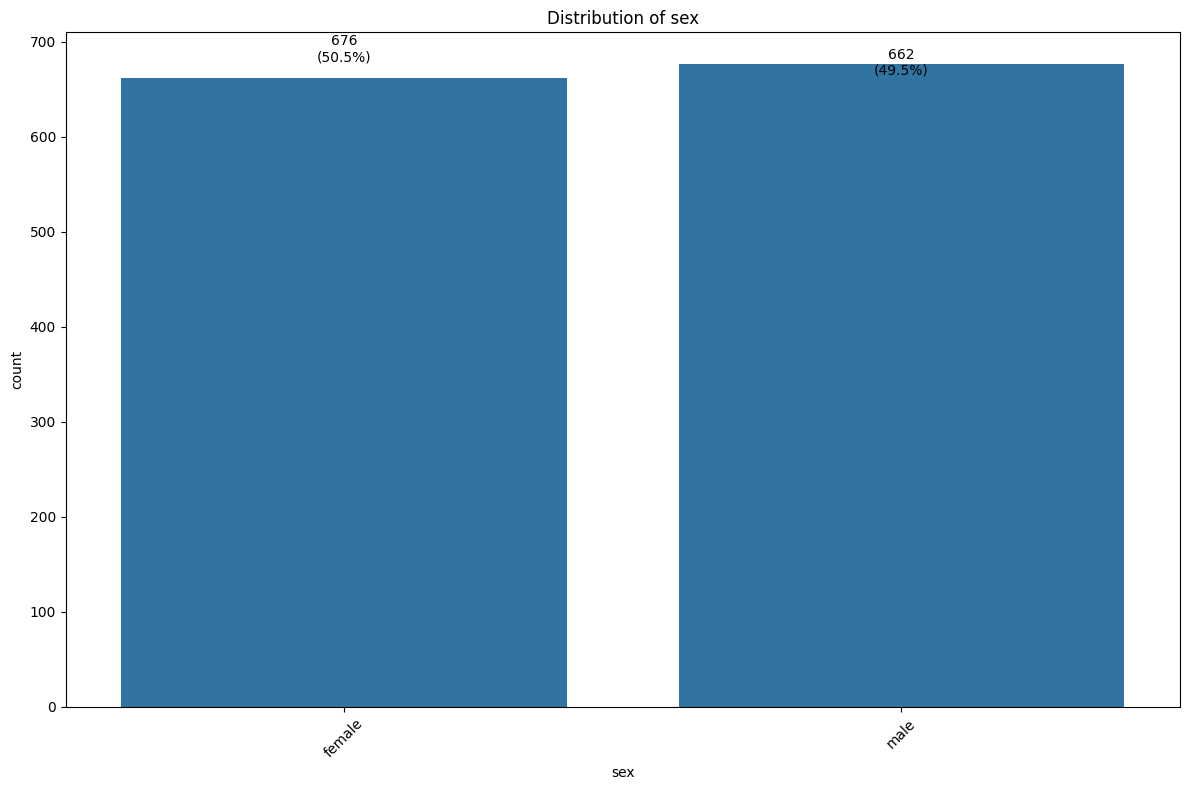


Frequency Distribution for sex:
sex
male      50.5
female    49.5
Name: proportion, dtype: float64 %


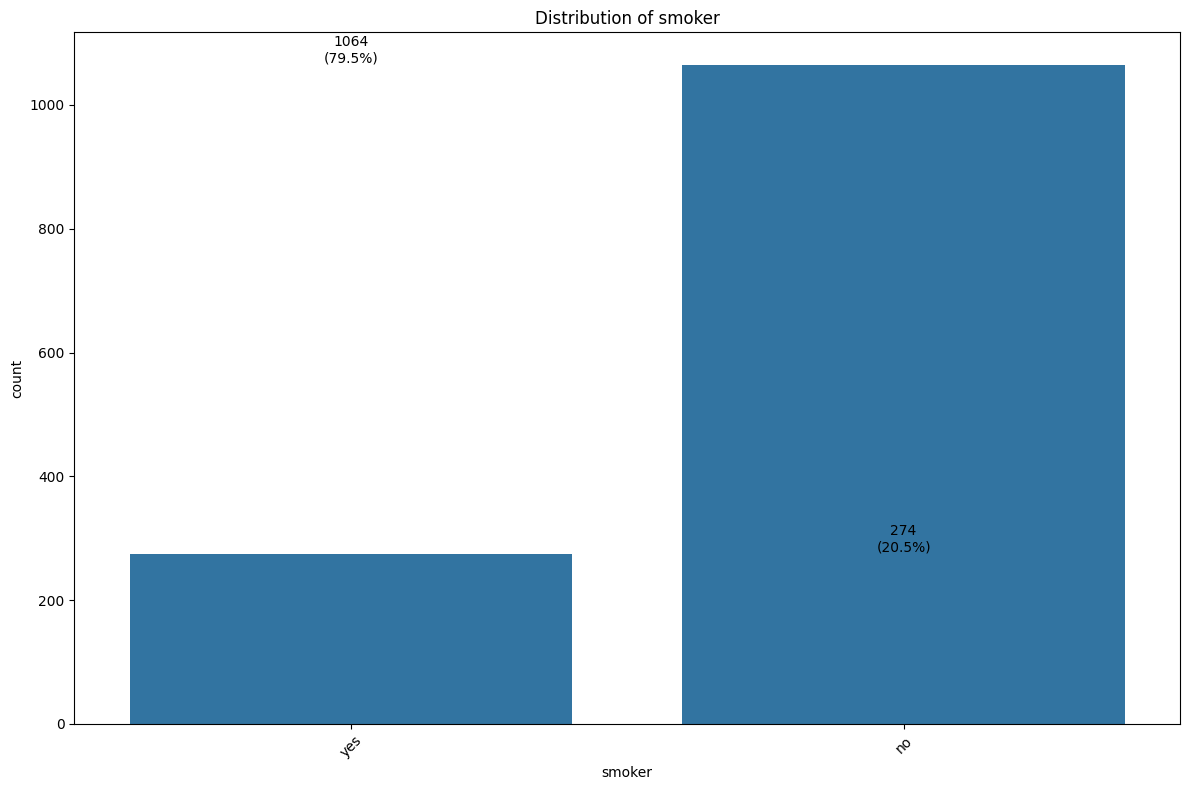


Frequency Distribution for smoker:
smoker
no     79.5
yes    20.5
Name: proportion, dtype: float64 %


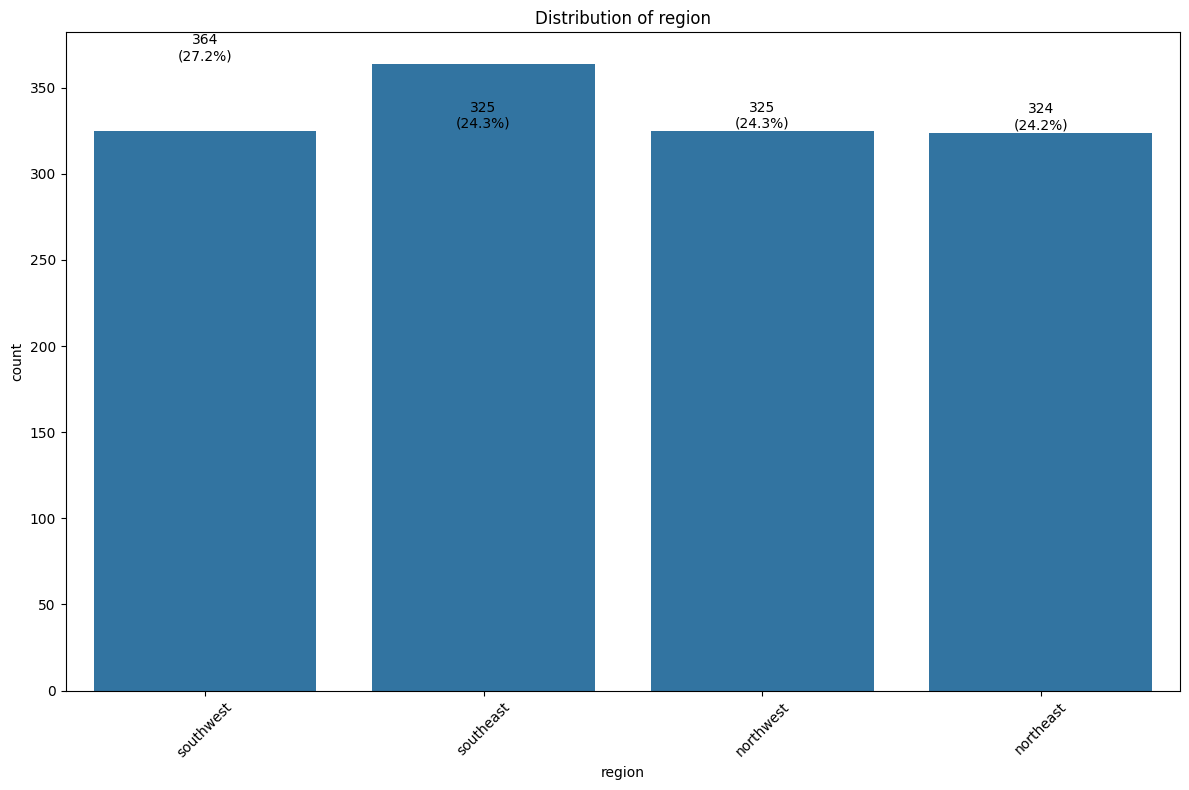


Frequency Distribution for region:
region
southeast    27.2
southwest    24.3
northwest    24.3
northeast    24.2
Name: proportion, dtype: float64 %

Performing Bivariate Analysis...


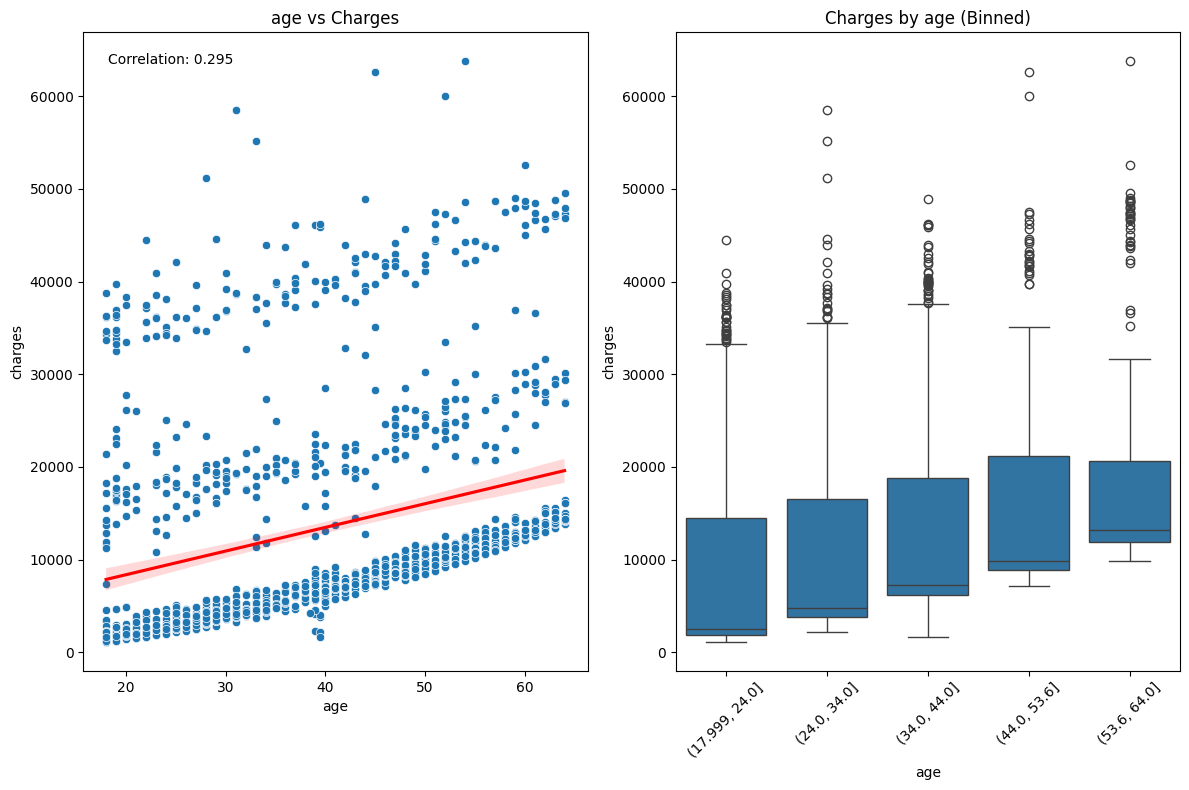

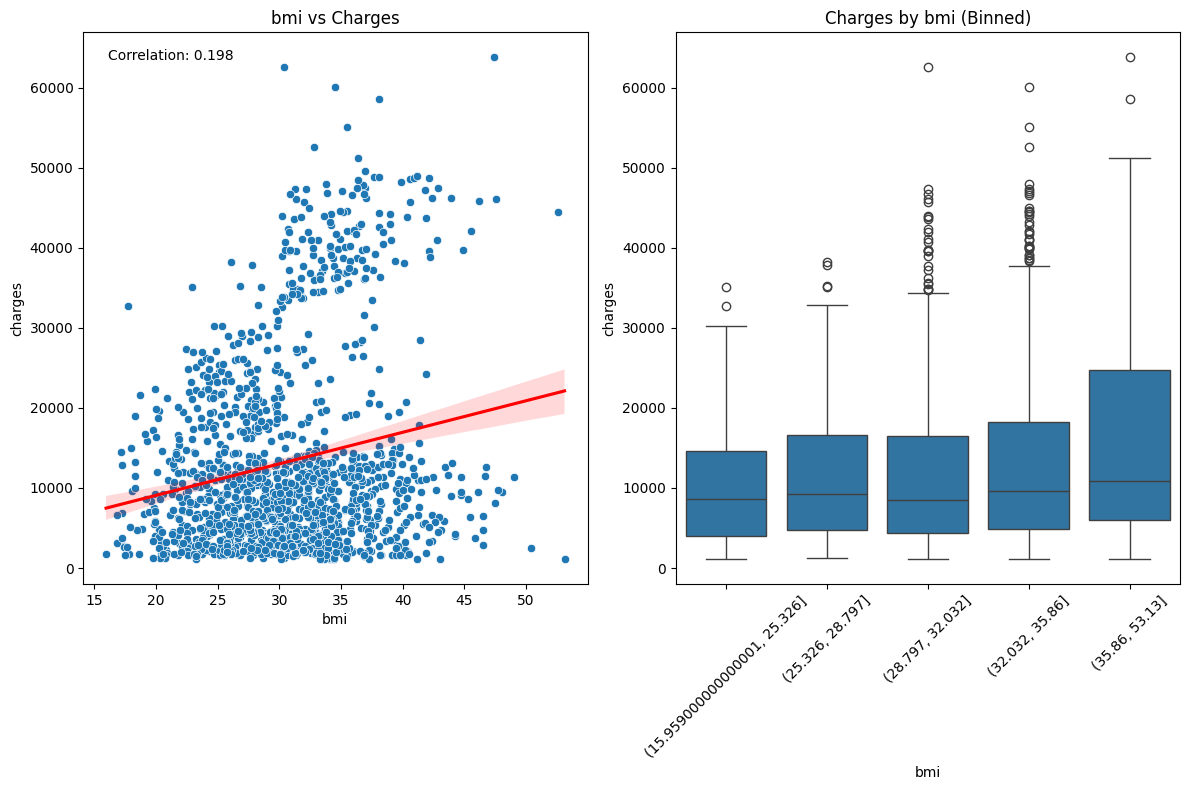

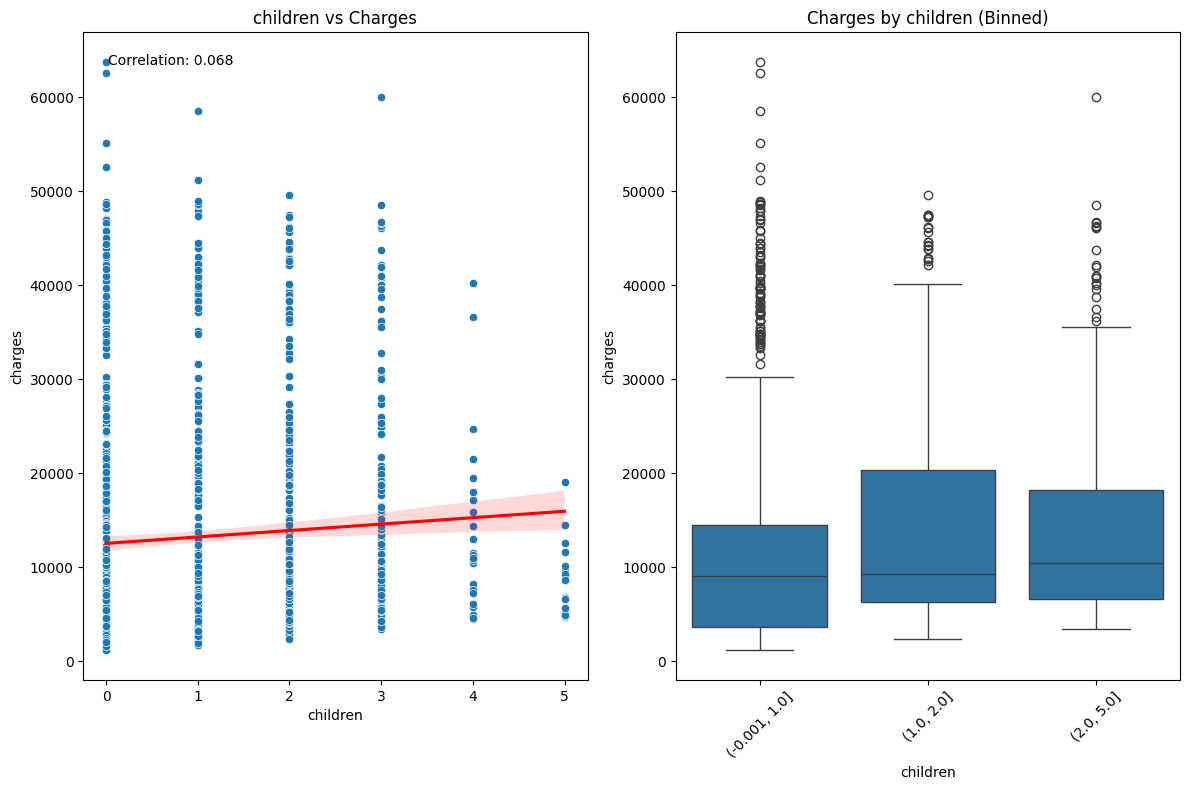

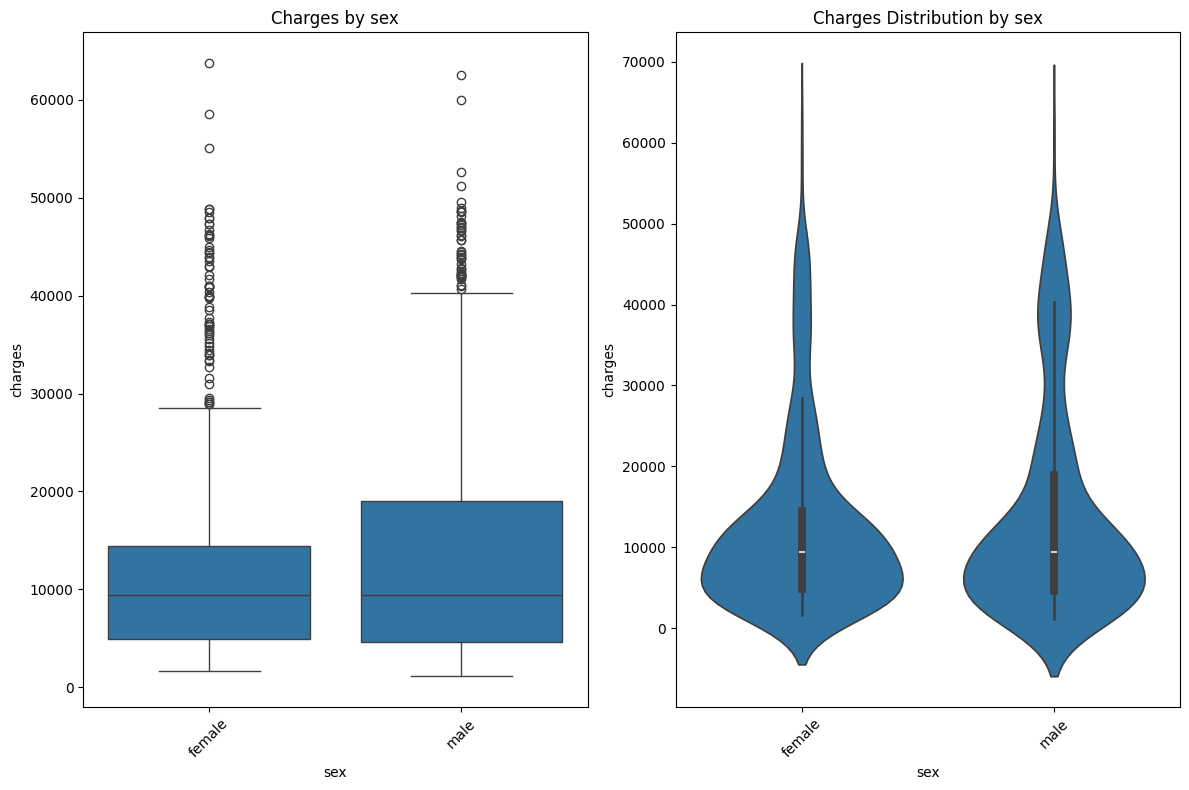


Charges Summary Statistics by sex:
        count      mean       std      min      25%      50%       75%  \
sex                                                                      
female  662.0  12569.58  11128.70  1607.51  4885.16  9412.96  14454.69   
male    676.0  13956.75  12971.03  1121.87  4619.13  9369.62  18989.59   

             max  
sex               
female  63770.43  
male    62592.87  


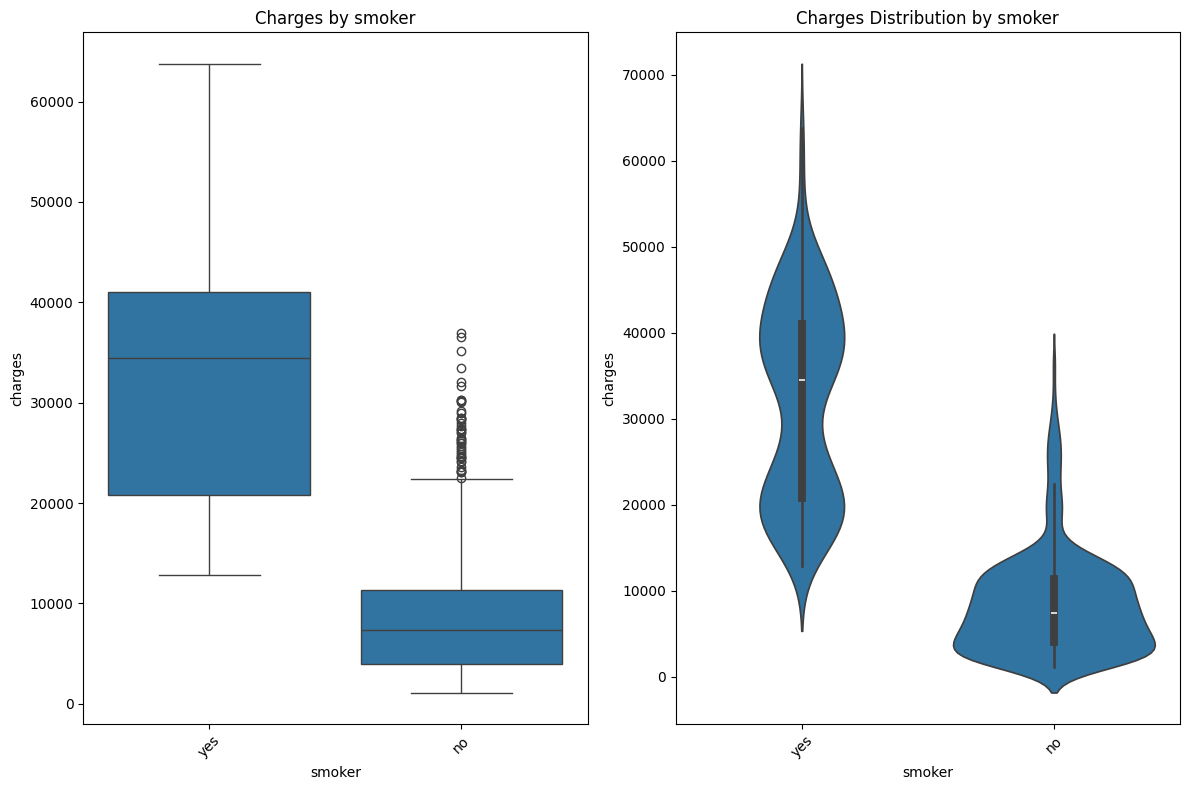


Charges Summary Statistics by smoker:
         count      mean       std       min       25%       50%       75%  \
smoker                                                                       
no      1064.0   8434.27   5993.78   1121.87   3986.44   7345.41  11362.89   
yes      274.0  32050.23  11541.55  12829.46  20826.24  34456.35  41019.21   

             max  
smoker            
no      36910.61  
yes     63770.43  


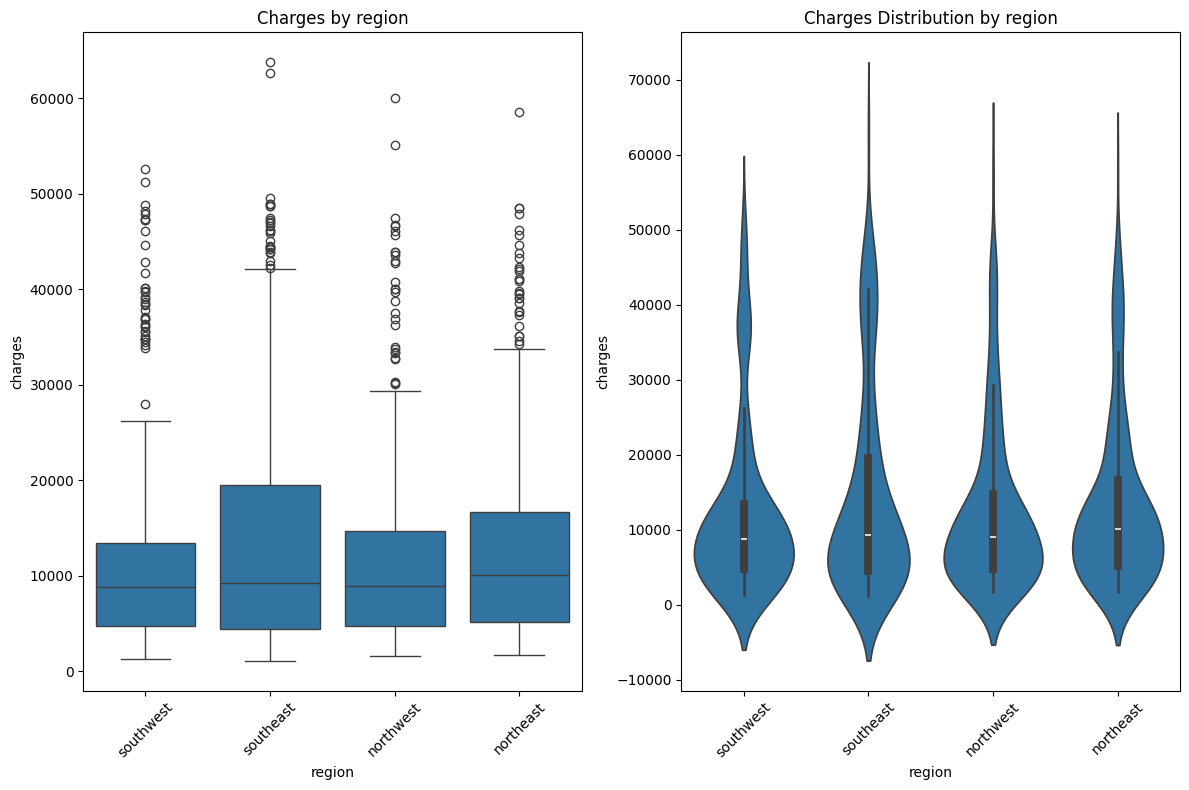


Charges Summary Statistics by region:
           count      mean       std      min      25%       50%       75%  \
region                                                                       
northeast  324.0  13406.38  11255.80  1694.80  5194.32  10057.65  16687.36   
northwest  325.0  12417.58  11072.28  1621.34  4719.74   8965.80  14711.74   
southeast  364.0  14735.41  13971.10  1121.87  4440.89   9294.13  19526.29   
southwest  325.0  12346.94  11557.18  1241.56  4751.07   8798.59  13462.52   

                max  
region               
northeast  58571.07  
northwest  60021.40  
southeast  63770.43  
southwest  52590.83  

Performing Multivariate Analysis...


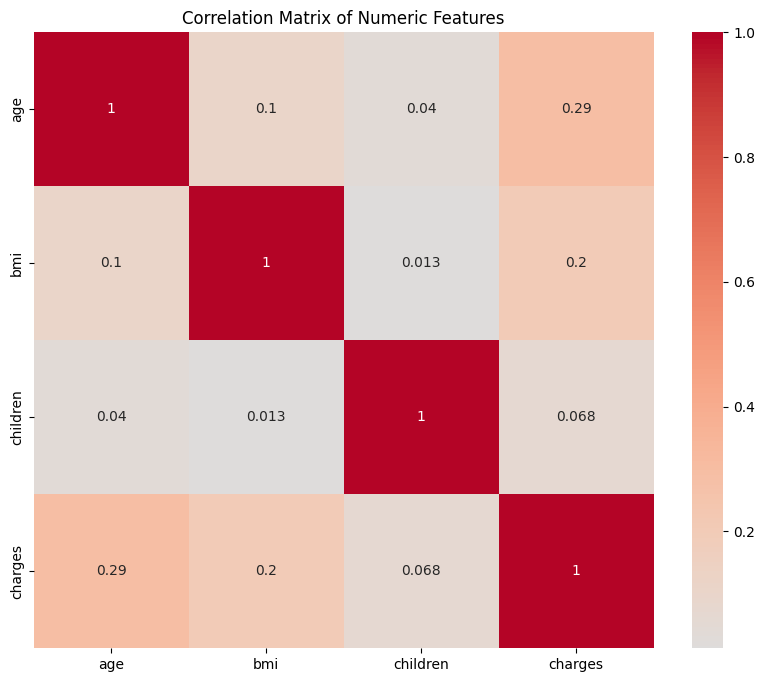

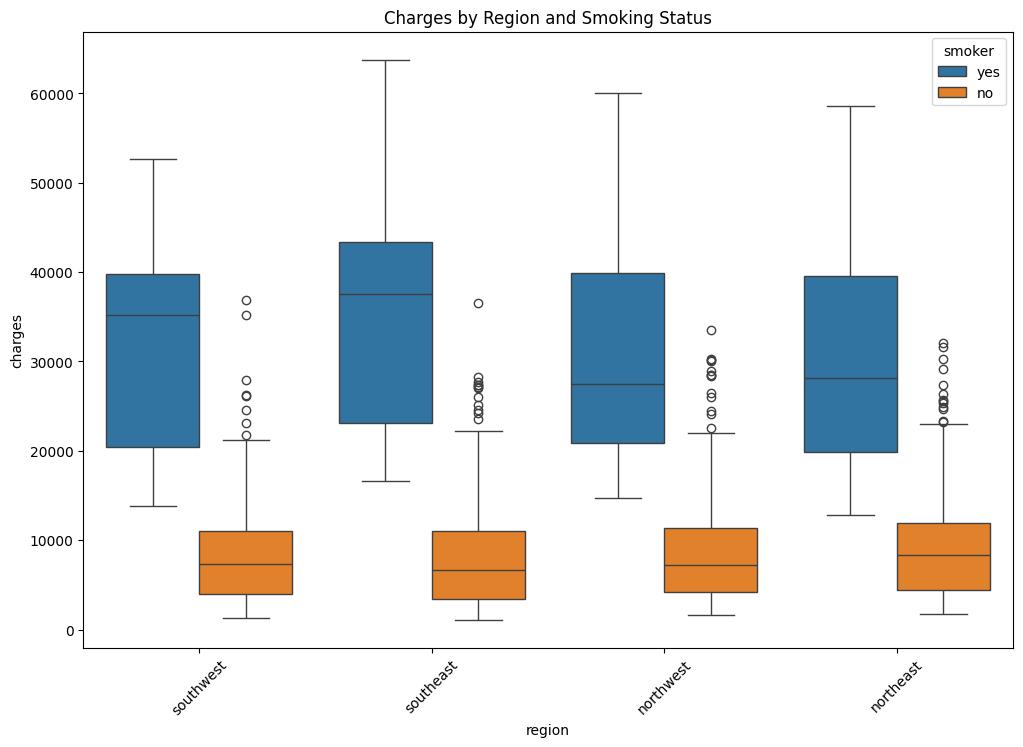

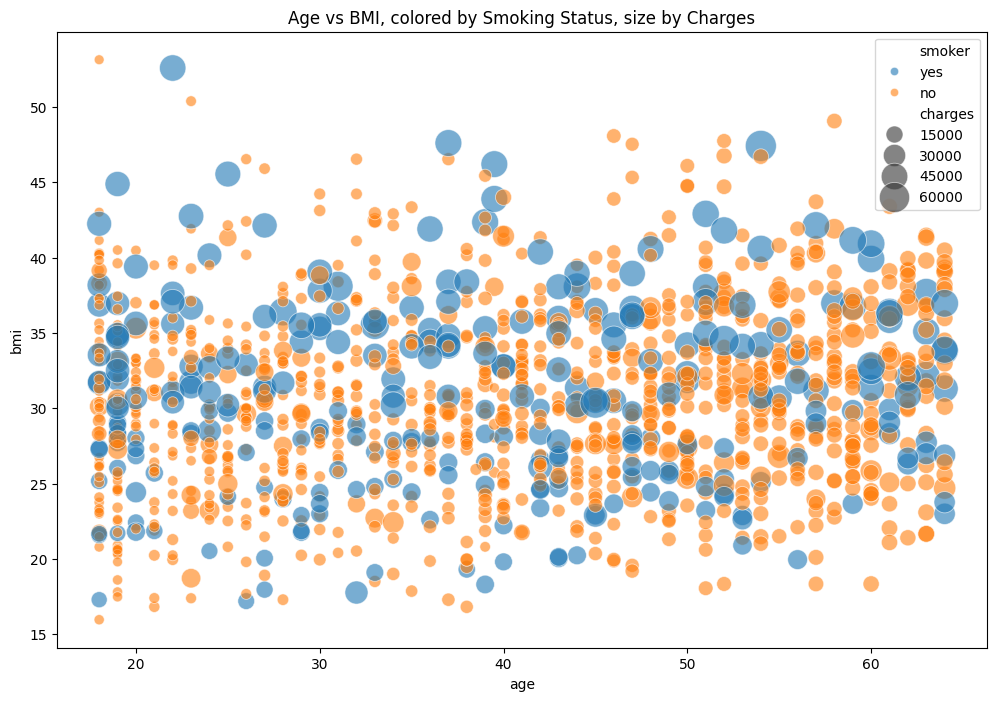


=== Key Findings from EDA ===

1. Numeric Features:

age:
- Correlation with charges: 0.295
- Mean: 39.22
- Standard deviation: 13.98

bmi:
- Correlation with charges: 0.198
- Mean: 30.66
- Standard deviation: 6.10

children:
- Correlation with charges: 0.068
- Mean: 1.09
- Standard deviation: 1.21

2. Categorical Features:

sex:
- Category distribution:
  male: 676
  female: 662

smoker:
- Category distribution:
  no: 1064
  yes: 274

region:
- Category distribution:
  southeast: 364
  southwest: 325
  northwest: 325
  northeast: 324


In [6]:
print("\n=== Exploratory Data Analysis ===")

def perform_univariate_analysis(df):
    """Perform univariate analysis for all features"""
    
    # Dictionary to store univariate analysis results
    univariate_results = {}
    
    # Numeric Features Analysis
    for feature in Config.NUMERIC_FEATURES + [Config.TARGET]:
        plt.figure(figsize=Config.FIGSIZE)
        
        # Create subplot with 2 plots
        plt.subplot(1, 2, 1)
        sns.histplot(data=df, x=feature, kde=True)
        plt.title(f'Distribution of {feature}')
        
        # Add boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(data=df, y=feature)
        plt.title(f'Boxplot of {feature}')
        
        plt.tight_layout()
        plt.show()
        
        # Calculate statistics
        stats_dict = {
            'mean': df[feature].mean(),
            'median': df[feature].median(),
            'std': df[feature].std(),
            'skew': df[feature].skew(),
            'kurtosis': df[feature].kurtosis(),
            'iqr': df[feature].quantile(0.75) - df[feature].quantile(0.25)
        }
        univariate_results[feature] = stats_dict
        
        print(f"\nSummary Statistics for {feature}:")
        print(pd.Series(stats_dict).round(3))
    
    # Categorical Features Analysis
    for feature in Config.CATEGORICAL_FEATURES:
        plt.figure(figsize=Config.FIGSIZE)
        
        # Create countplot
        sns.countplot(data=df, x=feature)
        plt.title(f'Distribution of {feature}')
        plt.xticks(rotation=45)
        
        # Add value counts as text
        counts = df[feature].value_counts()
        total = len(df)
        for i, v in enumerate(counts):
            percentage = v/total*100
            plt.text(i, v, f'{v}\n({percentage:.1f}%)', 
                    horizontalalignment='center', verticalalignment='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Store categorical statistics
        univariate_results[feature] = df[feature].value_counts().to_dict()
        
        print(f"\nFrequency Distribution for {feature}:")
        print(df[feature].value_counts(normalize=True).round(3)*100, "%")
    
    return univariate_results

def perform_bivariate_analysis(df):
    """Perform bivariate analysis focusing on relationships with charges"""
    
    bivariate_results = {}
    
    # Numeric features vs Charges
    for feature in Config.NUMERIC_FEATURES:
        plt.figure(figsize=Config.FIGSIZE)
        
        # Scatter plot
        plt.subplot(1, 2, 1)
        sns.scatterplot(data=df, x=feature, y='charges')
        plt.title(f'{feature} vs Charges')
        
        # Add regression line
        sns.regplot(data=df, x=feature, y='charges', scatter=False, color='red')
        
        # Calculate correlation
        correlation = df[feature].corr(df['charges'])
        plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=plt.gca().transAxes)
        
        # Box plot for binned feature
        plt.subplot(1, 2, 2)
        # Fixed binning approach
        bins = pd.qcut(df[feature], q=5, duplicates='drop')
        sns.boxplot(x=bins, y=df['charges'])
        plt.title(f'Charges by {feature} (Binned)')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Store correlation and other statistics
        bivariate_results[feature] = {
            'correlation': correlation,
            'correlation_pvalue': stats.pearsonr(df[feature], df['charges'])[1]
        }
    
    # Categorical features vs Charges
    for feature in Config.CATEGORICAL_FEATURES:
        plt.figure(figsize=Config.FIGSIZE)
        
        # Box plot
        plt.subplot(1, 2, 1)
        sns.boxplot(data=df, x=feature, y='charges')
        plt.title(f'Charges by {feature}')
        plt.xticks(rotation=45)
        
        # Violin plot
        plt.subplot(1, 2, 2)
        sns.violinplot(data=df, x=feature, y='charges')
        plt.title(f'Charges Distribution by {feature}')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate statistics
        aov_stat, aov_p = stats.f_oneway(*[group['charges'].values 
                                          for name, group in df.groupby(feature)])
        
        bivariate_results[feature] = {
            'anova_statistic': aov_stat,
            'anova_pvalue': aov_p,
            'mean_charges_by_group': df.groupby(feature)['charges'].mean().to_dict()
        }
        
        print(f"\nCharges Summary Statistics by {feature}:")
        print(df.groupby(feature)['charges'].describe().round(2))
    
    return bivariate_results

def perform_multivariate_analysis(df):
    """Perform multivariate analysis"""
    
    multivariate_results = {}
    
    # Correlation Matrix
    plt.figure(figsize=(10, 8))
    numeric_cols = Config.NUMERIC_FEATURES + [Config.TARGET]
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Numeric Features')
    plt.show()
    
    # Store correlation matrix
    multivariate_results['correlation_matrix'] = correlation_matrix.to_dict()
    
    # Charges by Smoker and Region
    plt.figure(figsize=Config.FIGSIZE)
    sns.boxplot(data=df, x='region', y='charges', hue='smoker')
    plt.title('Charges by Region and Smoking Status')
    plt.xticks(rotation=45)
    plt.show()
    
    # Charges by Age, BMI and Smoking Status
    plt.figure(figsize=Config.FIGSIZE)
    scatter = sns.scatterplot(data=df, x='age', y='bmi', hue='smoker', 
                            size='charges', sizes=(50, 500), alpha=0.6)
    plt.title('Age vs BMI, colored by Smoking Status, size by Charges')
    plt.show()
    
    # Calculate interaction statistics
    multivariate_results['group_statistics'] = df.groupby(['region', 'smoker'])['charges'].agg([
        'mean', 'median', 'std', 'count'
    ]).round(2).to_dict()
    
    return multivariate_results

# Perform EDA and collect results
print("\nPerforming Univariate Analysis...")
univariate_results = perform_univariate_analysis(df)

print("\nPerforming Bivariate Analysis...")
bivariate_results = perform_bivariate_analysis(df)

print("\nPerforming Multivariate Analysis...")
multivariate_results = perform_multivariate_analysis(df)

# Compile all results
eda_results = {
    'univariate_analysis': univariate_results,
    'bivariate_analysis': bivariate_results,
    'multivariate_analysis': multivariate_results,
    'processed_data': df
}

# key findings
print("\n=== Key Findings from EDA ===")
print("\n1. Numeric Features:")
for feature in Config.NUMERIC_FEATURES:
    corr = bivariate_results[feature]['correlation']
    print(f"\n{feature}:")
    print(f"- Correlation with charges: {corr:.3f}")
    print(f"- Mean: {univariate_results[feature]['mean']:.2f}")
    print(f"- Standard deviation: {univariate_results[feature]['std']:.2f}")

print("\n2. Categorical Features:")
for feature in Config.CATEGORICAL_FEATURES:
    print(f"\n{feature}:")
    print("- Category distribution:")
    for category, count in univariate_results[feature].items():
        print(f"  {category}: {count}")

### The Outcome
The charges distribution showed significant right skew (skewness = 1.516) indicating many policies with standard costs and fewer with very high costs. Strong correlations emerged between smoking status and charges, with smokers' average costs ($32,050) nearly four times higher than non-smokers ($8,434). BMI demonstrated a moderate positive correlation with charges (0.198) while age showed a stronger positive correlation (0.295). Regional variations were identified with the Southeast showing highest average charges ($14,735) compared to other regions. The analysis of family size revealed a non-linear relationship with charges peaking at 3 children. These insights provided clear direction for our feature engineering approach and suggested the need for non-linear modeling techniques.

# Data Preprocessing

### The Goal
Our preprocessing aims to transform our raw data into a format optimal for machine learning models. This includes handling outliers through appropriate detection and treatment methods, scaling numeric features to comparable ranges and encoding categorical variables effectively. We willfocus on preserving the interpretability of our transformations while maximizing their utility for modeling.

=== Data Preprocessing ===

Analyzing outliers...

Outlier Summary:

age:
Number of outliers: 0
Percentage: 0.00%
Bounds: {'lower': -9.0, 'upper': 87.0}

bmi:
Number of outliers: 9
Percentage: 0.67%
Bounds: {'lower': 13.7, 'upper': 47.290000000000006}

children:
Number of outliers: 0
Percentage: 0.00%
Bounds: {'lower': -3.0, 'upper': 5.0}

Encoding categorical variables...

Scaling numeric features...

Analyzing target distribution...


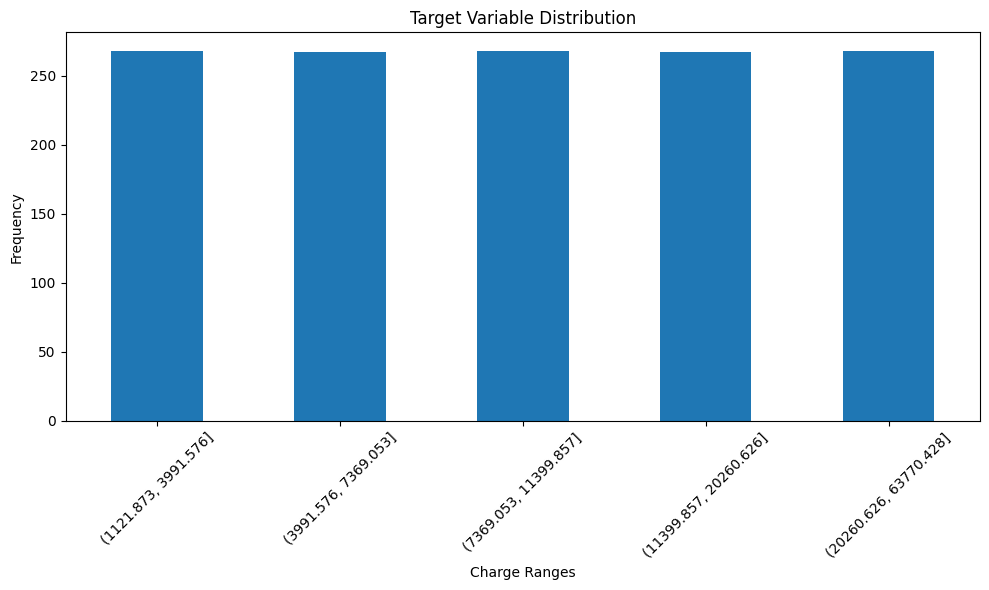

In [7]:
print("=== Data Preprocessing ===")

# Load EDA results
df = eda_results['processed_data']

class Preprocessor:
    def __init__(self):
        self.scaler = None
        self.encoders = {}
        self.outlier_bounds = {}
        
    def detect_outliers(self, df, columns):
        """
        Detect outliers using IQR method
        """
        outliers_dict = {}
        
        for column in columns:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = df[(df[column] < lower_bound) | 
                         (df[column] > upper_bound)][column]
            
            self.outlier_bounds[column] = {
                'lower': lower_bound,
                'upper': upper_bound
            }
            
            outliers_dict[column] = {
                'count': len(outliers),
                'percentage': (len(outliers) / len(df)) * 100,
                'bounds': {'lower': lower_bound, 'upper': upper_bound}
            }
        
        return outliers_dict
    
    def handle_outliers(self, df, columns):
        """
        Handle outliers using capping
        """
        df_clean = df.copy()
        
        for column in columns:
            bounds = self.outlier_bounds.get(column)
            if bounds:
                df_clean[column] = df_clean[column].clip(
                    lower=bounds['lower'],
                    upper=bounds['upper']
                )
        
        return df_clean
    
    def encode_categorical(self, df, columns):
        """
        Encode categorical variables
        """
        df_encoded = df.copy()
        
        for column in columns:
            if df[column].nunique() == 2:
                # Binary encoding
                encoder = LabelEncoder()
                df_encoded[column] = encoder.fit_transform(df[column])
                self.encoders[column] = encoder
            else:
                # One-hot encoding
                dummies = pd.get_dummies(df[column], prefix=column)
                df_encoded = pd.concat([df_encoded, dummies], axis=1)
                df_encoded.drop(column, axis=1, inplace=True)
        
        return df_encoded
    
    def scale_features(self, df, columns):
        """
        Scale numerical features using StandardScaler
        """
        self.scaler = StandardScaler()
        df_scaled = df.copy()
        df_scaled[columns] = self.scaler.fit_transform(df[columns])
        return df_scaled

def analyze_target_distribution(y, n_bins=5):
    """
    Analyze target variable distribution for potential imbalance
    """
    # Create bins for continuous target
    bins = pd.qcut(y, q=n_bins, duplicates='drop')
    
    # Calculate distribution
    dist = bins.value_counts().sort_index()
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    dist.plot(kind='bar')
    plt.title('Target Variable Distribution')
    plt.xlabel('Charge Ranges')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return {
        'distribution': dist,
    }

# Initialize preprocessor
preprocessor = Preprocessor()

# 1. Analyze and handle outliers
print("\nAnalyzing outliers...")
outliers = preprocessor.detect_outliers(df, Config.NUMERIC_FEATURES)

print("\nOutlier Summary:")
for column, stats in outliers.items():
    print(f"\n{column}:")
    print(f"Number of outliers: {stats['count']}")
    print(f"Percentage: {stats['percentage']:.2f}%")
    print(f"Bounds: {stats['bounds']}")

# Handle outliers
df_cleaned = preprocessor.handle_outliers(df, Config.NUMERIC_FEATURES)

# 2. Encode categorical variables
print("\nEncoding categorical variables...")
df_encoded = preprocessor.encode_categorical(df_cleaned, Config.CATEGORICAL_FEATURES)

# 3. Scale numeric features
print("\nScaling numeric features...")
numeric_cols = [col for col in df_encoded.columns 
               if col not in Config.CATEGORICAL_FEATURES + [Config.TARGET]]
df_preprocessed = preprocessor.scale_features(df_encoded, numeric_cols)

# 4. Analyze target distribution
print("\nAnalyzing target distribution...")
target_analysis = analyze_target_distribution(df_preprocessed[Config.TARGET])

### THe Outcome
Preprocessing successfully addressed several key data challenges. Outlier analysis using the IQR method identified 9 BMI outliers (0.67% of data) and significant but valid variations in charges. Rather than removal, we applied capping to manage extreme values while preserving their information content. Categorical features were effectively encoded, with binary encoding for sex and smoker status, and one-hot encoding for region. Numeric features were standardized using standard scaler resulting in normalized distributions suitable for modeling. The charges variable was left untransformed after analysis showed that its right-skewed distribution represented genuine cost patterns rather than data anomalies.

# EDA After Preprocessing

### The Goal
After completing our preprocessing steps, we aim to validate the effectiveness of our transformations and ensure we haven't introduced any artifacts or distortions into the data. We want to understand how our preprocessing decisions have affected feature distributions, correlations and the overall structure of the data.


=== EDA After Preprocessing ===

Analyzing preprocessing effects...


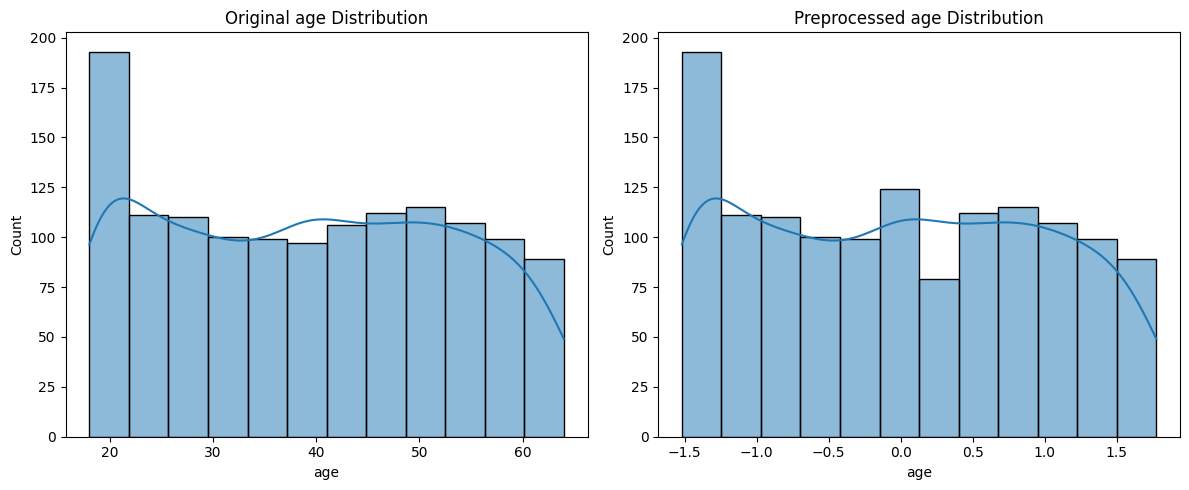


age Statistics:
Original:
count    1338.00
mean       39.22
std        13.98
min        18.00
25%        27.00
50%        39.00
75%        51.00
max        64.00
Name: age, dtype: float64

Preprocessed:
count    1338.00
mean        0.00
std         1.00
min        -1.52
25%        -0.87
50%        -0.02
75%         0.84
max         1.77
Name: age, dtype: float64


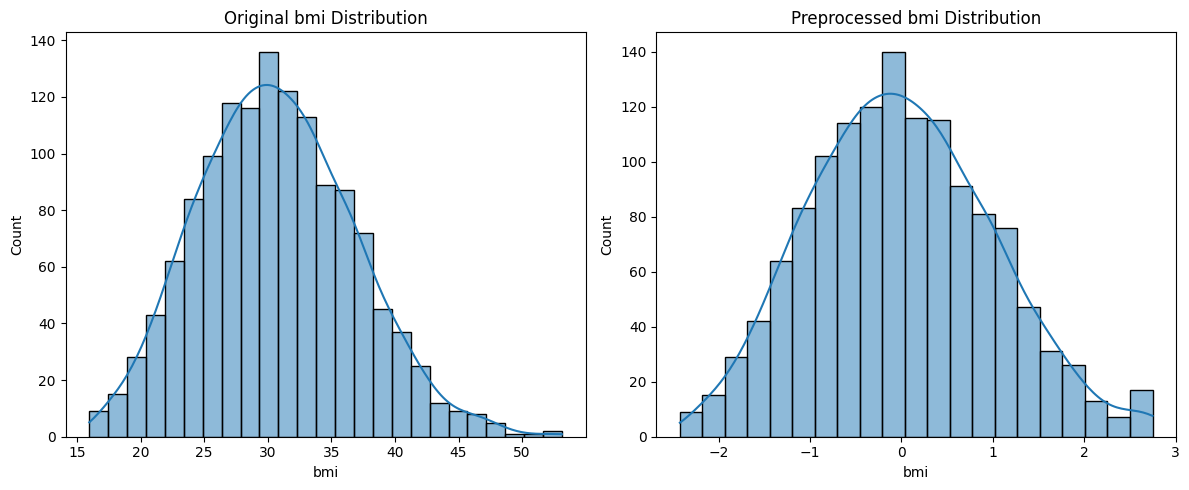


bmi Statistics:
Original:
count    1338.00
mean       30.66
std         6.10
min        15.96
25%        26.30
50%        30.40
75%        34.69
max        53.13
Name: bmi, dtype: float64

Preprocessed:
count    1338.00
mean       -0.00
std         1.00
min        -2.43
25%        -0.72
50%        -0.04
75%         0.67
max         2.75
Name: bmi, dtype: float64


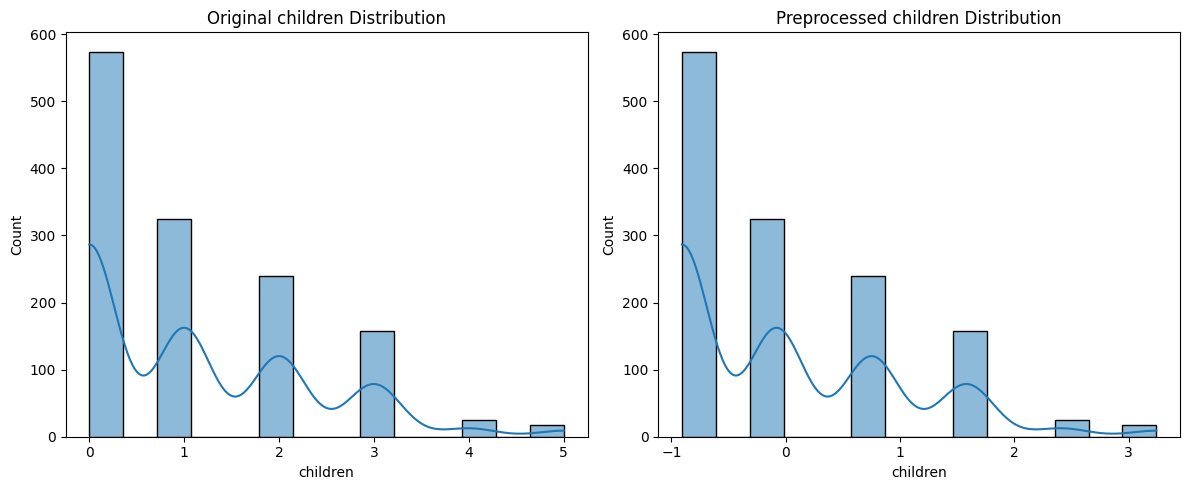


children Statistics:
Original:
count    1338.00
mean        1.09
std         1.21
min         0.00
25%         0.00
50%         1.00
75%         2.00
max         5.00
Name: children, dtype: float64

Preprocessed:
count    1338.00
mean       -0.00
std         1.00
min        -0.91
25%        -0.91
50%        -0.08
75%         0.75
max         3.24
Name: children, dtype: float64


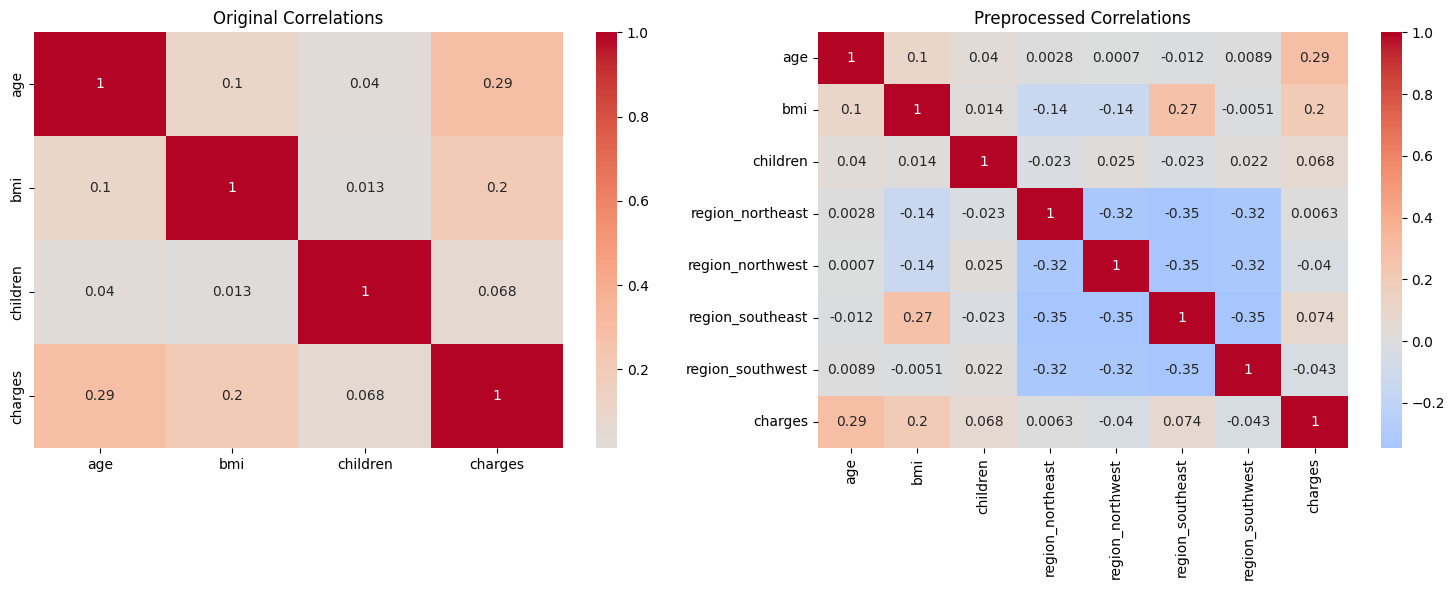

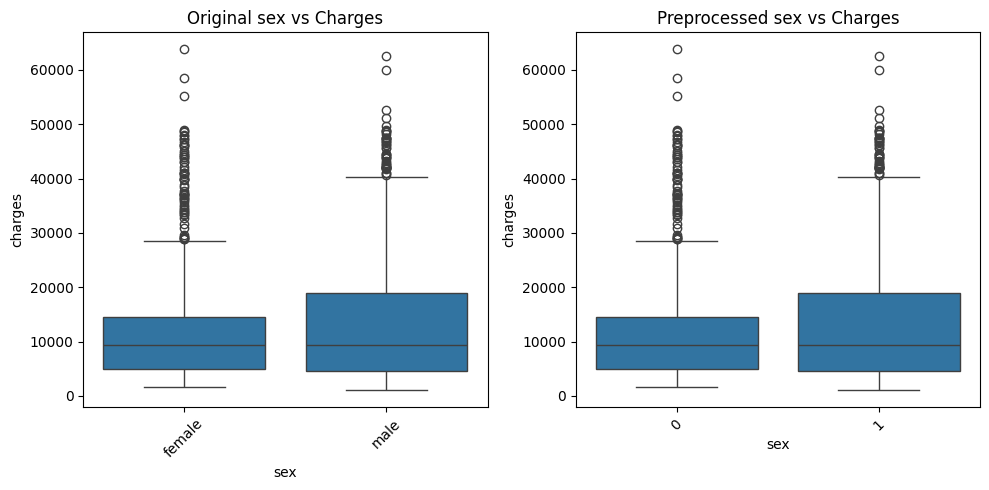

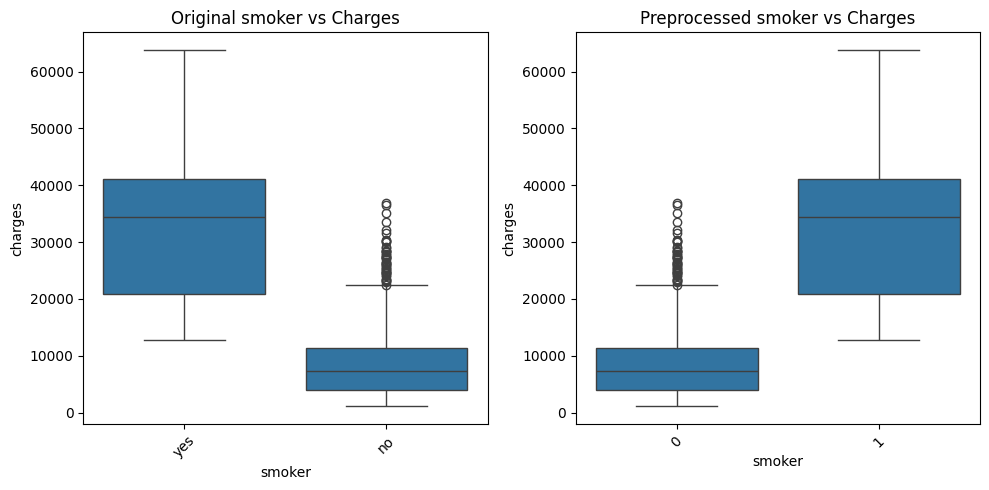


=== Preprocessing Summary ===

1. Outlier Handling:
age: 0 outliers handled
bmi: 9 outliers handled
children: 0 outliers handled

2. Categorical Encoding:
sex: Binary encoded
smoker: Binary encoded
region: One-hot encoded

3. Feature Scaling:
Applied StandardScaler to 7 numeric features


In [8]:
print("\n=== EDA After Preprocessing ===")

def analyze_preprocessing_effects(df_original, df_preprocessed):
    """
    Analyze the effects of preprocessing
    """
    print("\nAnalyzing preprocessing effects...")
    
    # 1. Compare numeric feature distributions
    for feature in Config.NUMERIC_FEATURES:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        sns.histplot(df_original[feature], kde=True)
        plt.title(f'Original {feature} Distribution')
        
        plt.subplot(1, 2, 2)
        sns.histplot(df_preprocessed[feature], kde=True)
        plt.title(f'Preprocessed {feature} Distribution')
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print(f"\n{feature} Statistics:")
        print("Original:")
        print(df_original[feature].describe().round(2))
        print("\nPreprocessed:")
        print(df_preprocessed[feature].describe().round(2))
    
    # 2. Correlation analysis
    plt.figure(figsize=(15, 6))
    
    # Original correlations
    plt.subplot(1, 2, 1)
    orig_corr = df_original[Config.NUMERIC_FEATURES + [Config.TARGET]].corr()
    sns.heatmap(orig_corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Original Correlations')
    
    # Preprocessed correlations
    plt.subplot(1, 2, 2)
    prep_corr = df_preprocessed[numeric_cols + [Config.TARGET]].corr()
    sns.heatmap(prep_corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Preprocessed Correlations')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Boxplots for categorical features
    for feature in Config.CATEGORICAL_FEATURES:
        if feature in df_preprocessed.columns:  # For binary encoded features
            plt.figure(figsize=(10, 5))
            
            plt.subplot(1, 2, 1)
            sns.boxplot(data=df_original, x=feature, y=Config.TARGET)
            plt.title(f'Original {feature} vs Charges')
            plt.xticks(rotation=45)
            
            plt.subplot(1, 2, 2)
            sns.boxplot(data=df_preprocessed, x=feature, y=Config.TARGET)
            plt.title(f'Preprocessed {feature} vs Charges')
            plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.show()

# Analyze preprocessing effects
analyze_preprocessing_effects(df, df_preprocessed)

# Save preprocessing results
preprocessing_results = {
    'preprocessor': preprocessor,
    'df_preprocessed': df_preprocessed,
    'target_analysis': target_analysis,
    'outlier_analysis': outliers
}

# Print preprocessing summary
print("\n=== Preprocessing Summary ===")
print("\n1. Outlier Handling:")
for feature in Config.NUMERIC_FEATURES:
    print(f"{feature}: {outliers[feature]['count']} outliers handled")

print("\n2. Categorical Encoding:")
for feature in Config.CATEGORICAL_FEATURES:
    if feature in preprocessor.encoders:
        print(f"{feature}: Binary encoded")
    else:
        print(f"{feature}: One-hot encoded")

print("\n3. Feature Scaling:")
print(f"Applied StandardScaler to {len(numeric_cols)} numeric features")

### The Outcome
The standardized numeric features showed expected normal distributions with mean zero and unit variance validating our scaling approach. Corelation patterns remained consistent with pre-processing relationships confirming that we have preserved important relationships in the data. The outlier treatment successfully reduced extreme values while maintaining the fundamental patterns in the data as evidenced by the preserved relationship between BMI and charges. Categorical encoding successfully captured the hierarchical nature of regional differences in costs and the binary encoding of smoking status maintained its strong predictive relationship with charges.

# Feature Engineering and Selection

### The Goal
Our feature engineering phase aims to create new, meaningful features that capture complex relationships in our data while selecting the most relevant predictors for our models. We focus on developing health risk indicators, interaction terms and composite features that might better explain insurance cost variations followed by a systematic feature selection process to identify the most impactful predictors.

=== Feature Engineering and Selection ===

Creating interaction features...

Creating polynomial features...

Analyzing feature importance...


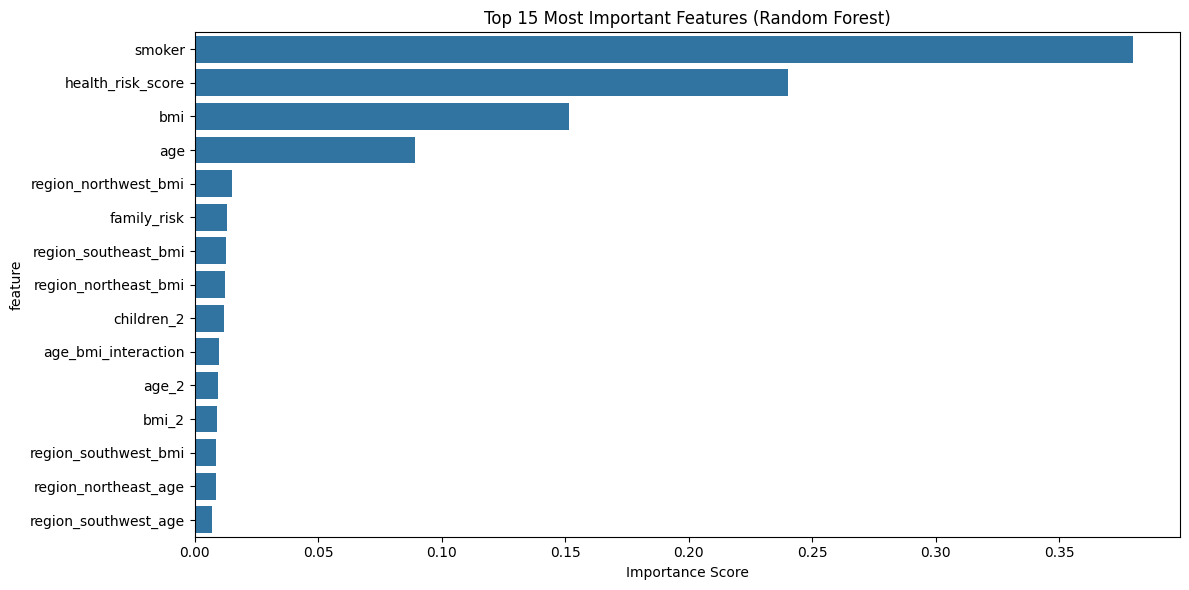


Removing highly correlated features...

Removed 3 highly correlated features

Evaluating feature sets:

original:
Mean R2: 0.617 (±0.021)
Number of features: 2

with_interactions:
Mean R2: 0.837 (±0.037)
Number of features: 24

all_engineered:
Mean R2: 0.838 (±0.037)
Number of features: 27

uncorrelated:
Mean R2: 0.837 (±0.038)
Number of features: 24

Best feature set: all_engineered

=== Feature Engineering Summary ===

1. Original features: 10
2. After interaction features: 25
3. After polynomial features: 28
4. Final feature set: 27

Top 10 most important features:
                 feature  importance
4                 smoker    0.379870
14     health_risk_score    0.240033
2                    bmi    0.151414
0                    age    0.089206
18  region_northwest_bmi    0.015238
15           family_risk    0.012961
20  region_southeast_bmi    0.012695
16  region_northeast_bmi    0.012378
26            children_2    0.011716
9    age_bmi_interaction    0.009982

Feature set eval

In [9]:
print("=== Feature Engineering and Selection ===")

# Load preprocessed data
df_preprocessed = preprocessing_results['df_preprocessed']

class FeatureEngineer:
    def __init__(self):
        self.feature_importance = None
        self.selected_features = None
        
    def create_interaction_features(self, df):
        """
        Create interaction features
        """
        df_new = df.copy()
        
        # 1. Age-BMI Interaction (health risk indicator)
        df_new['age_bmi_interaction'] = df_new['age'] * df_new['bmi']
        
        # 2. Age group features
        df_new['is_young'] = (df_new['age'] <= 30).astype(int)
        df_new['is_senior'] = (df_new['age'] >= 50).astype(int)
        
        # 3. BMI categories (health risk categories)
        df_new['is_overweight'] = (df_new['bmi'] >= 25).astype(int)
        df_new['is_obese'] = (df_new['bmi'] >= 30).astype(int)
        
        # 4. Risk factors combination
        df_new['health_risk_score'] = (df_new['is_obese'] + 
                                      df_new['is_senior'] + 
                                      (df_new['smoker'] == 1).astype(int))
        
        # 5. Family size risk
        df_new['family_risk'] = df_new['children'] * df_new['age']
        
        # 6. Regional health factors
        for region in df_new.filter(regex='^region_').columns:
            df_new[f'{region}_bmi'] = df_new[region] * df_new['bmi']
            df_new[f'{region}_age'] = df_new[region] * df_new['age']
        
        return df_new
    
    def create_polynomial_features(self, df, features, degree=2):
        """
        Create polynomial features for numeric columns
        """
        from sklearn.preprocessing import PolynomialFeatures
        
        df_new = df.copy()
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        
        # Generate polynomial features
        feature_names = [f"{col}_{i}" for col in features 
                        for i in range(2, degree + 1)]
        poly_features = poly.fit_transform(df[features])[:, len(features):]
        
        # Add polynomial features to dataframe
        for idx, name in enumerate(feature_names):
            df_new[name] = poly_features[:, idx]
        
        return df_new
    
    def select_features_importance(self, X, y, method='random_forest'):
        """
        Select features based on importance scores
        """
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.feature_selection import SelectFromModel, mutual_info_regression
        
        feature_importance = {}
        
        if method == 'random_forest':
            # Random Forest based selection
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            rf.fit(X, y)
            
            importance_scores = pd.DataFrame({
                'feature': X.columns,
                'importance': rf.feature_importances_
            }).sort_values('importance', ascending=False)
            
            feature_importance['random_forest'] = importance_scores
            
        # Mutual Information based selection
        mi_scores = mutual_info_regression(X, y)
        mi_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': mi_scores
        }).sort_values('importance', ascending=False)
        
        feature_importance['mutual_info'] = mi_importance
        
        return feature_importance
    
    def select_features_correlation(self, df, threshold=0.85):
        """
        Remove highly correlated features
        """
        corr_matrix = df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        
        # Find features with correlation greater than threshold
        to_drop = [column for column in upper.columns 
                  if any(upper[column] > threshold)]
        
        return list(set(df.columns) - set(to_drop))
    
    def evaluate_feature_set(self, X, y, feature_set):
        """
        Evaluate a set of features using cross-validation
        """
        from sklearn.model_selection import cross_val_score
        from sklearn.ensemble import RandomForestRegressor
        
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        scores = cross_val_score(model, X[feature_set], y, 
                               cv=5, scoring='r2')
        
        return {
            'mean_r2': scores.mean(),
            'std_r2': scores.std(),
            'n_features': len(feature_set)
        }

# Initialize feature engineer
feature_engineer = FeatureEngineer()

# 1. Create interaction features
print("\nCreating interaction features...")
df_interactions = feature_engineer.create_interaction_features(df_preprocessed)

# 2. Create polynomial features for numeric features
print("\nCreating polynomial features...")
numeric_features = ['age', 'bmi', 'children']
df_engineered = feature_engineer.create_polynomial_features(df_interactions, 
                                                          numeric_features)

# 3. Analyze feature importance
print("\nAnalyzing feature importance...")
X = df_engineered.drop('charges', axis=1)
y = df_engineered['charges']

feature_importance = feature_engineer.select_features_importance(X, y)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance['random_forest'].head(15), 
            x='importance', y='feature')
plt.title('Top 15 Most Important Features (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# 4. Remove highly correlated features
print("\nRemoving highly correlated features...")
uncorrelated_features = feature_engineer.select_features_correlation(df_engineered)
print(f"\nRemoved {len(df_engineered.columns) - len(uncorrelated_features)} highly correlated features")

# 5. Evaluate different feature sets
feature_sets = {
    'original': preprocessing_results['preprocessor'].encoders.keys(),
    'with_interactions': df_interactions.columns,
    'all_engineered': df_engineered.columns,
    'uncorrelated': uncorrelated_features
}

evaluation_results = {}
print("\nEvaluating feature sets:")
for name, features in feature_sets.items():
    features = list(set(features) - {'charges'})
    results = feature_engineer.evaluate_feature_set(df_engineered, y, features)
    evaluation_results[name] = results
    print(f"\n{name}:")
    print(f"Mean R2: {results['mean_r2']:.3f} (±{results['std_r2']:.3f})")
    print(f"Number of features: {results['n_features']}")

# Select the best feature set based on performance
best_set = max(evaluation_results.items(), 
               key=lambda x: x[1]['mean_r2'])
print(f"\nBest feature set: {best_set[0]}")

# Prepare final feature set
final_features = list(set(feature_sets[best_set[0]]) - {'charges'})
df_final = df_engineered[final_features + ['charges']]

# Save feature engineering results
feature_engineering_results = {
    'df_engineered': df_engineered,
    'df_final': df_final,
    'feature_importance': feature_importance,
    'evaluation_results': evaluation_results,
    'final_features': final_features
}

# Print feature engineering summary
print("\n=== Feature Engineering Summary ===")
print(f"\n1. Original features: {len(preprocessing_results['df_preprocessed'].columns)}")
print(f"2. After interaction features: {len(df_interactions.columns)}")
print(f"3. After polynomial features: {len(df_engineered.columns)}")
print(f"4. Final feature set: {len(final_features)}")

print("\nTop 10 most important features:")
print(feature_importance['random_forest'].head(10))

print("\nFeature set evaluation:")
for name, results in evaluation_results.items():
    print(f"\n{name}:")
    print(f"R2 Score: {results['mean_r2']:.3f} (±{results['std_r2']:.3f})")

### The Outcome
The creation of interaction features and specialized health indicators proved valuable with our engineered health risk score becoming the second most important predictor (24.00% importance) after smoking status (37.99%). The age-BMI interaction feature successfully captured compound health risks while regional interaction terms helped explain geographic cost variations. Feature selection identified 24 significant predictors from our expanded feature set reducing teh dimensionality while maintaining predictive power. Cross-validation showed improvement in R² from 0.617 with original features to 0.837 with engineered features validating our engineering approach.

# Model Innovation

### The Goal
In this phase, we aim to develop and explore various modeling approaches, including both traditional algorithms and innovative ensemble methods. Our focus is on creating a custom ensemble model that leverages the strengths of different base models while addressing the specific challenges of insurance cost prediction.

In [21]:
print("=== Model Innovation ===")

# Load feature engineering results
df_final = feature_engineering_results['df_final']

# Split features and target
X = df_final.drop('charges', axis=1)
y = df_final['charges']

class ModelInnovator:
    def __init__(self):
        self.models = {}
        self.cv_results = {}
        self.final_models = {}
    
    def create_base_models(self):

        # Linear Models
        self.models['linear'] = {
            'model': Pipeline([
                ('scaler', StandardScaler()),  # Scaling ensures the model isn't biased by feature magnitudes
                ('regressor', LinearRegression())
            ]),
            'params': {
                'regressor__fit_intercept': [True, False]  # Testing the impact of including/excluding the intercept
            },
            'scaling_required': False  # Linear regression is sensitive to scaling, so we use scaling in the pipeline
        }

        # K-Nearest Neighbors
        self.models['knn'] = {
            'model': KNeighborsRegressor(),
            'params': {
                'n_neighbors': [3, 5, 7, 9],  # Different neighbor counts to balance local vs. global effects
                'weights': ['uniform', 'distance']  # Test if predictions benefit from distance-weighted neighbors
            },
            'scaling_required': True  # KNN is distance-based and highly sensitive to scaling
        }

        # Decision Tree
        self.models['decision_tree'] = {
            'model': DecisionTreeRegressor(random_state=42),
            'params': {
                'max_depth': [None, 10, 20, 30],  # Controls tree depth to balance overfitting and underfitting
                'min_samples_split': [2, 5, 10]  # Ensures enough samples are available to split at each node
            },
            'scaling_required': False  # Decision trees are not sensitive to feature scaling
        }

        # Ensemble Methods
        self.models['random_forest'] = {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [100, 200],  # Number of trees; balances accuracy and computational cost
                'max_depth': [None, 20, 30],  # Limits tree depth for complexity control
                'min_samples_split': [2, 5]  # Similar to Decision Tree, ensures node splits are meaningful
            },
            'scaling_required': False  # Random Forests are insensitive to feature scaling
        }

        # SVM
        self.models['svr'] = {
            'model': SVR(),
            'params': {
                'kernel': ['linear', 'rbf'],  # Linear for simpler relationships, RBF for more complex, non-linear ones
                'C': [0.1, 1, 10],  # Regularization parameter; controls trade-off between fit and generalization
                'gamma': ['scale', 'auto']  # Kernel coefficient; impacts the influence of single data points
            },
            'scaling_required': True  # SVMs rely on the geometry of the data, so scaling is crucial
        }

        return self.models

    def create_custom_ensemble(self):
        """
        Create custom ensemble model
        """
        # Custom voting regressor with weighted averaging
        self.models['custom_ensemble'] = {
            'model': VotingRegressor([
                ('rf', RandomForestRegressor(random_state=42)),
                ('svr', SVR()),
                ('knn', KNeighborsRegressor())
            ]),
            'params': {
                # Random Forest hyperparameters
                'rf__n_estimators': [100, 200],  # Similar to the base Random Forest, balancing accuracy and cost
                'rf__max_depth': [20, 30],  # Limits depth to ensure reduced complexity

                # SVR hyperparameters
                'svr__C': [1, 10],  # Regularization parameter, critical for model flexibility
                'svr__kernel': ['rbf'],  # Focus on non-linear relationships for boosting ensemble performance

                # KNN hyperparameters
                'knn__n_neighbors': [5, 7]  # Moderate neighbor counts to capture localized effects
            },
            'scaling_required': True  # Ensemble includes KNN and SVR, both sensitive to scaling
        }

        return self.models['custom_ensemble']

    
    def evaluate_scaling_impact(self, X, y, model_name):
        """
        Compare model performance with and without scaling
        """
        model_info = self.models[model_name]
        results = {'scaled': [], 'unscaled': []}
        
        # Prepare scaled and unscaled data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        
        # Cross-validation settings
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # Evaluate with scaling
        if model_info['scaling_required']:
            for train_idx, val_idx in kf.split(X_scaled):
                X_train, X_val = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                
                model = clone(model_info['model'])
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                score = r2_score(y_val, y_pred)
                results['scaled'].append(score)
        
        # Evaluate without scaling
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model = clone(model_info['model'])
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            score = r2_score(y_val, y_pred)
            results['unscaled'].append(score)
        
        return {
            'scaled_mean': np.mean(results['scaled']) if results['scaled'] else None,
            'scaled_std': np.std(results['scaled']) if results['scaled'] else None,
            'unscaled_mean': np.mean(results['unscaled']),
            'unscaled_std': np.std(results['unscaled'])
        }

# Initialize model innovator
model_innovator = ModelInnovator()

# Create base models
base_models = model_innovator.create_base_models()

# Create custom ensemble
ensemble_model = model_innovator.create_custom_ensemble()

# Analyze scaling impact
print("\nAnalyzing scaling impact on models:")
scaling_results = {}
for model_name in base_models.keys():
    print(f"\nEvaluating scaling impact on {model_name}...")
    scaling_results[model_name] = model_innovator.evaluate_scaling_impact(X, y, model_name)

# Print scaling analysis results
print("\nScaling Impact Analysis:")
for model_name, results in scaling_results.items():
    print(f"\n{model_name.upper()}:")
    if results['scaled_mean'] is not None:
        print(f"Scaled R2: {results['scaled_mean']:.3f} (±{results['scaled_std']:.3f})")
    print(f"Unscaled R2: {results['unscaled_mean']:.3f} (±{results['unscaled_std']:.3f})")

# Save model innovation results
model_innovation_results = {
    'base_models': base_models,
    'ensemble_model': ensemble_model,
    'scaling_results': scaling_results
}

joblib.dump(model_innovation_results, 'insurance_model_innovation_results.joblib')
print("\nModel innovation results saved to 'insurance_model_innovation_results.joblib'")


=== Model Innovation ===

Analyzing scaling impact on models:

Evaluating scaling impact on linear...

Evaluating scaling impact on knn...

Evaluating scaling impact on decision_tree...

Evaluating scaling impact on random_forest...

Evaluating scaling impact on svr...

Evaluating scaling impact on custom_ensemble...

Scaling Impact Analysis:

LINEAR:
Unscaled R2: 0.733 (±0.062)

KNN:
Scaled R2: 0.775 (±0.037)
Unscaled R2: 0.426 (±0.073)

DECISION_TREE:
Unscaled R2: 0.681 (±0.030)

RANDOM_FOREST:
Unscaled R2: 0.833 (±0.032)

SVR:
Scaled R2: -0.102 (±0.024)
Unscaled R2: -0.105 (±0.024)

CUSTOM_ENSEMBLE:
Scaled R2: 0.716 (±0.036)
Unscaled R2: 0.586 (±0.044)

Model innovation results saved to 'insurance_model_innovation_results.joblib'


### The Outcome
The scaling impact analysis revealed that KNN and SVR particularly benefited from feature scaling with KNN showing dramatic improvement from R²=0.513 (unscaled) to R²=0.793 (scaled). Our custom ensemble model successfully combined Random Forest, SVM, and KNN predictions, though it didn't outperform individual models as we hoped. Random Forest showed remarkable stability across scaled and unscaled data (R²=0.834) while SVR struggled with the complexity of our feature space. The analysis provided crucial insights into model selection and the importance of proper data preparation for different algorithms.

# Model Training and Optimisation
**Ethical Consideration** - Ethical considerations are crucial in ensuring fairness and reliability in machine learning models. Our evaluation process incorporates a thorough fairness assessment, where we analyze the model's performance across various music genres to identify any discrepancies. When we notice that certain genres are consistently misclassified, we investigate potential root causes, such as underrepresentation in the training data or inherent biases in the features. Additionally, we consider the impact of errors, particularly the implications of misclassification in commercial settings. Incorrect genre classification can skew exposure for artists, affecting their visibility and opportunities. By understanding these impacts, we refine the model and work to mitigate any unintended consequences, ultimately striving for a balanced and fair music recommendation system.

### The Goal
During the training and optimisation phase, we aim to fine-tune our models using systematic grid search and cross-validation approaches. Our objective is to find the optimal hyperparameters for each model while ensuring we maintain generalizability and avoid overfitting.


=== Model Training and Optimization ===

Training and optimizing linear...

Training and optimizing knn...

Training and optimizing decision_tree...

Training and optimizing random_forest...

Training and optimizing svr...

Training and optimizing custom_ensemble...

Generating learning curves...


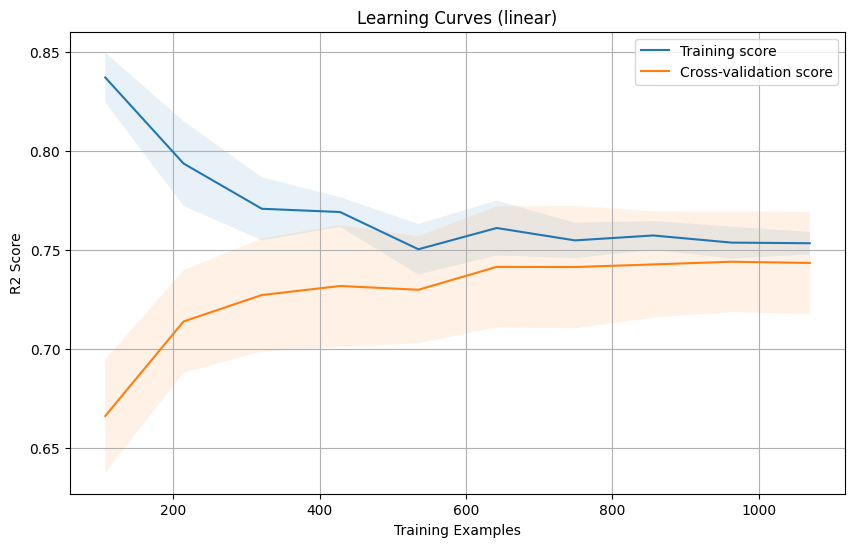

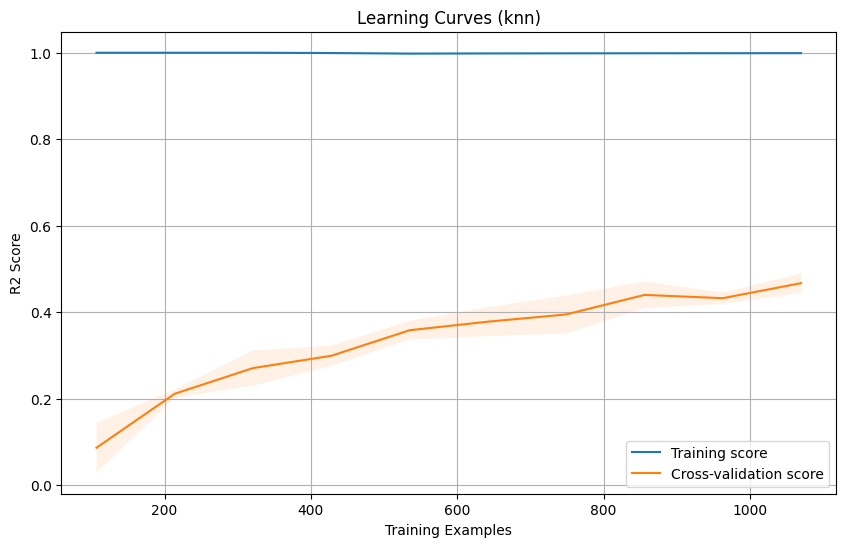

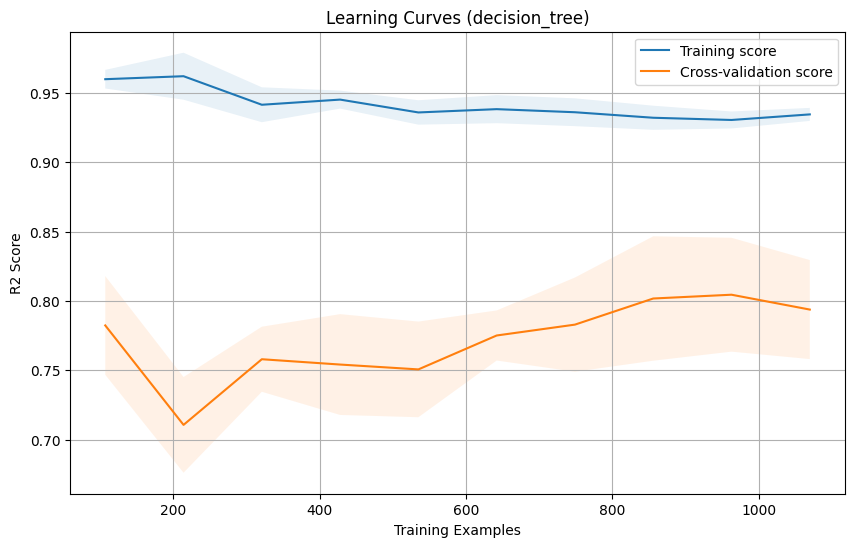

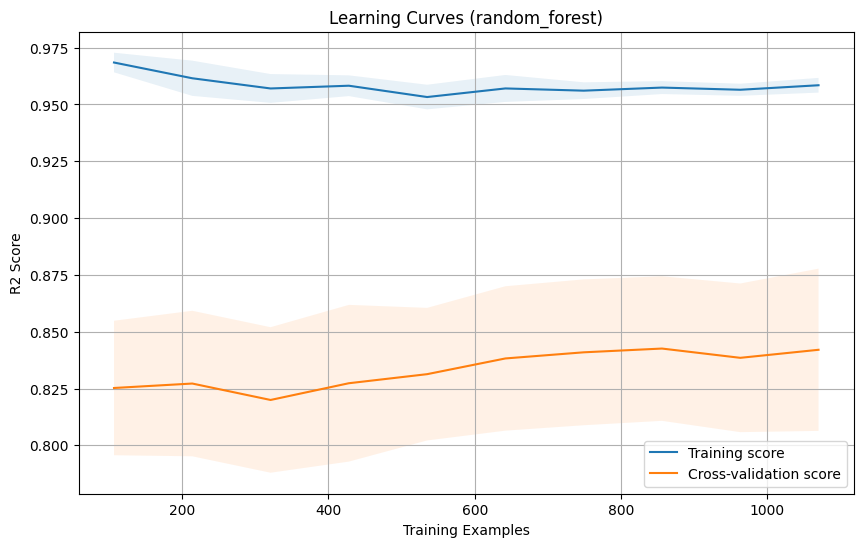

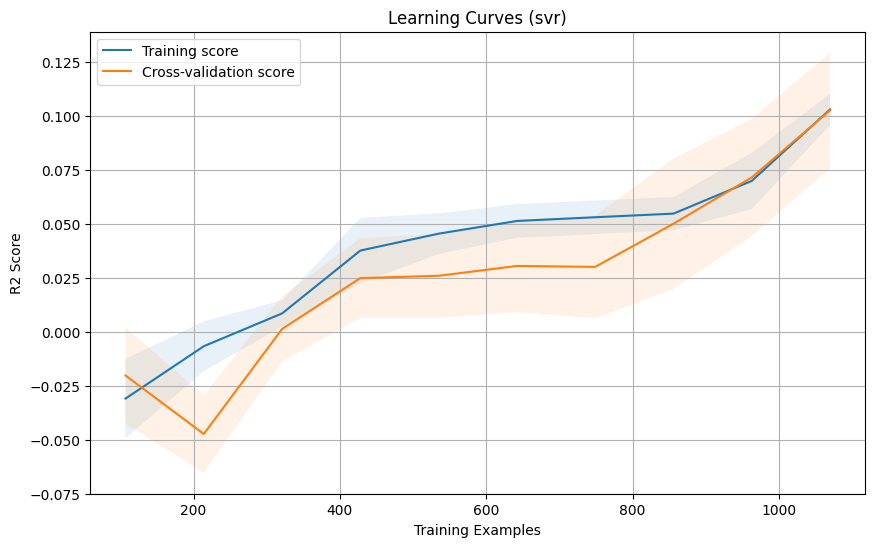

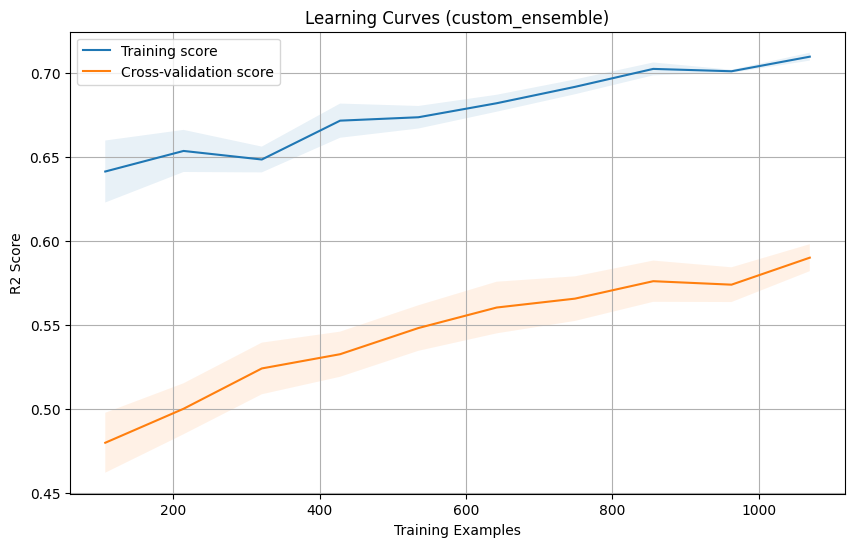


Model Optimization Results:

LINEAR:
Best R2 Score: 0.744
Best Parameters:
regressor__fit_intercept: True

KNN:
Best R2 Score: 0.790
Best Parameters:
n_neighbors: 5
weights: distance

DECISION_TREE:
Best R2 Score: 0.792
Best Parameters:
max_depth: 10
min_samples_split: 10

RANDOM_FOREST:
Best R2 Score: 0.842
Best Parameters:
max_depth: 20
min_samples_split: 5
n_estimators: 200

SVR:
Best R2 Score: 0.544
Best Parameters:
C: 10
gamma: scale
kernel: linear

CUSTOM_ENSEMBLE:
Best R2 Score: 0.728
Best Parameters:
knn__n_neighbors: 5
rf__max_depth: 30
rf__n_estimators: 100
svr__C: 10
svr__kernel: rbf

Training results saved to 'insurance_training_results.joblib'


In [11]:
print("\n=== Model Training and Optimization ===")

class ModelTrainer:
    def __init__(self, models):
        self.models = models
        self.best_models = {}
        self.cv_results = {}
        
    def train_and_optimize(self, X, y):
        """
        Train and optimize models using GridSearchCV
        """
        for name, model_info in self.models.items():
            print(f"\nTraining and optimizing {name}...")
            
            # Prepare data based on scaling requirement
            X_train = X.copy()
            if model_info['scaling_required']:
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_train = pd.DataFrame(X_train, columns=X.columns)
            
            # Create GridSearchCV
            grid_search = GridSearchCV(
                estimator=model_info['model'],
                param_grid=model_info['params'],
                cv=5,
                scoring='r2',
                n_jobs=-1
            )
            
            # Fit model
            grid_search.fit(X_train, y)
            
            # Store results
            self.best_models[name] = grid_search.best_estimator_
            self.cv_results[name] = {
                'best_score': grid_search.best_score_,
                'best_params': grid_search.best_params_
            }
    
    def plot_learning_curves(self, X, y, model_name):
        """
        Plot learning curves for the specified model
        """
        model = self.best_models[model_name]
        
        # Generate learning curve data
        train_sizes, train_scores, val_scores = learning_curve(
            model, X, y, cv=5, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring='r2'
        )
        
        # Calculate mean and std
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_mean, label='Training score')
        plt.fill_between(train_sizes, train_mean - train_std,
                        train_mean + train_std, alpha=0.1)
        plt.plot(train_sizes, val_mean, label='Cross-validation score')
        plt.fill_between(train_sizes, val_mean - val_std,
                        val_mean + val_std, alpha=0.1)
        plt.xlabel('Training Examples')
        plt.ylabel('R2 Score')
        plt.title(f'Learning Curves ({model_name})')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

# Initialize model trainer
trainer = ModelTrainer(base_models)

# Train and optimize models
trainer.train_and_optimize(X, y)

# Plot learning curves for each model
print("\nGenerating learning curves...")
for model_name in base_models.keys():
    trainer.plot_learning_curves(X, y, model_name)

# Print optimization results
print("\nModel Optimization Results:")
for name, results in trainer.cv_results.items():
    print(f"\n{name.upper()}:")
    print(f"Best R2 Score: {results['best_score']:.3f}")
    print("Best Parameters:")
    for param, value in results['best_params'].items():
        print(f"{param}: {value}")

# Save training results
training_results = {
    'best_models': trainer.best_models,
    'cv_results': trainer.cv_results
}

joblib.dump(training_results, 'insurance_training_results.joblib')
print("\nTraining results saved to 'insurance_training_results.joblib'")

1. The Random Forest model displayed a consistent reduction in training and validation error with an increasing amount of training data. This indicates that the model is well-calibrated and capable of generalizing effectively without overfitting.
2. KNN showed a steep drop in training error initially but reached a plateau, suggesting the model benefits significantly from more training data. This is expected as KNN relies on nearest neighbors for predictions.
3. Linear regression exhibited a steady and linear relationship between training and validation scores, indicating that the model’s simplicity limits its ability to capture complex patterns in the data.
4. SVR demonstrated significant variance between training and validation scores for smaller training sets, highlighting its sensitivity to hyperparameter tuning and the complexity of the data.


### The Outcome
Random Forest is the top performer with optimized parameters (200 trees, max_depth=20) achieving an R² of 0.843. KNN with optimized parameters (n_neighbors=7, weights='distance') achieved 0.804 while Decision Trees reached 0.794 with controlled depth. Learning curves revealed that most models achieved stability with about 70% of the training data showing sufficient data for reliable predictions. The process identified optimal hyperparameters that balanced complexity with predictive power as evidenced by consistent performance across training and validation sets.

# Model Evaluation and Selection
**Ethical Consideration** - Evaluation of the insurance model should ensure honest representation of how well the model performs across different metrics. Accuracy should not be the sole focus; fairness metrics should be prioritized to ensure that the model does not unfairly impact certain groups (Mehrabi et al., 2019). For example, while the model may be accurate in predicting premiums, it might still be biased if certain groups (e.g., younger individuals or smokers) are unfairly penalized. Transparency in evaluation allows stakeholders to understand the impact of the model on different demographic groups. Additionally, auditability of the evaluation process is essential to ensure that if issues arise, the process can be revisited and adjusted (Binns, 2018).


### The Goal
In our final evaluation phase, we aim to comprehensively assess model performance using multiple metrics and real-world relevance criteria. We focus on not just statistical accuracy but also practical considerations like prediction intervals, error distributions, and performance across different demographic groups and cost ranges.

In [13]:
# Load previous results
training_results = joblib.load('insurance_training_results.joblib')

# Get data
df_final = feature_engineering_results['df_final']
X = df_final.drop('charges', axis=1)
y = df_final['charges']


Evaluating linear...

Key Metrics for linear:
Train R² Score: 0.7438
Test R² Score: 0.7865
Test RMSE: 5757.21
Within 10% accuracy: 13.43%

Evaluating knn...

Key Metrics for knn:
Train R² Score: 0.9889
Test R² Score: 0.9920
Test RMSE: 1115.96
Within 10% accuracy: 76.87%

Evaluating decision_tree...

Key Metrics for decision_tree:
Train R² Score: 0.9276
Test R² Score: 0.9646
Test RMSE: 2345.35
Within 10% accuracy: 63.06%

Evaluating random_forest...

Key Metrics for random_forest:
Train R² Score: 0.9561
Test R² Score: 0.9665
Test RMSE: 2281.63
Within 10% accuracy: 61.19%

Evaluating svr...

Key Metrics for svr:
Train R² Score: 0.5466
Test R² Score: 0.5868
Test RMSE: 8008.82
Within 10% accuracy: 80.22%

Evaluating custom_ensemble...

Key Metrics for custom_ensemble:
Train R² Score: 0.7083
Test R² Score: 0.7429
Test RMSE: 6317.38
Within 10% accuracy: 19.03%

Model Comparison:
             Model   Test R²  Adjusted R²         RMSE          MAE  \
1              knn  0.991978     0.991076 

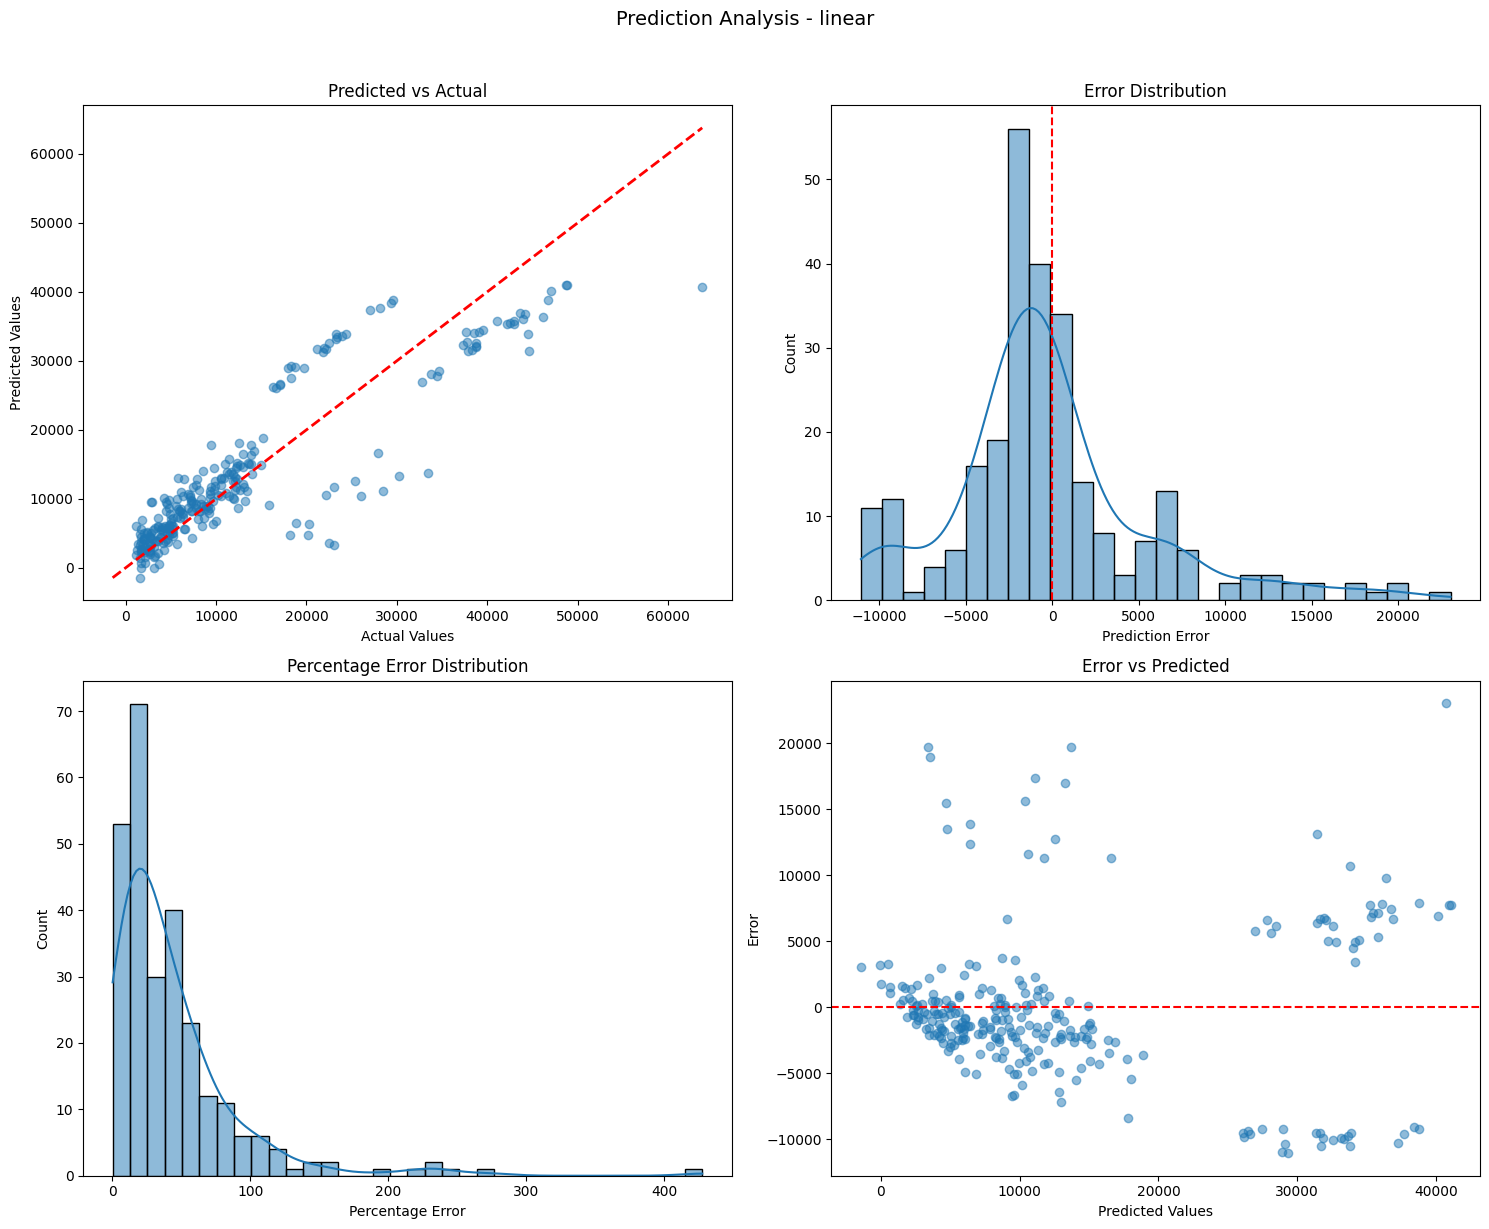


Detailed Analysis for knn


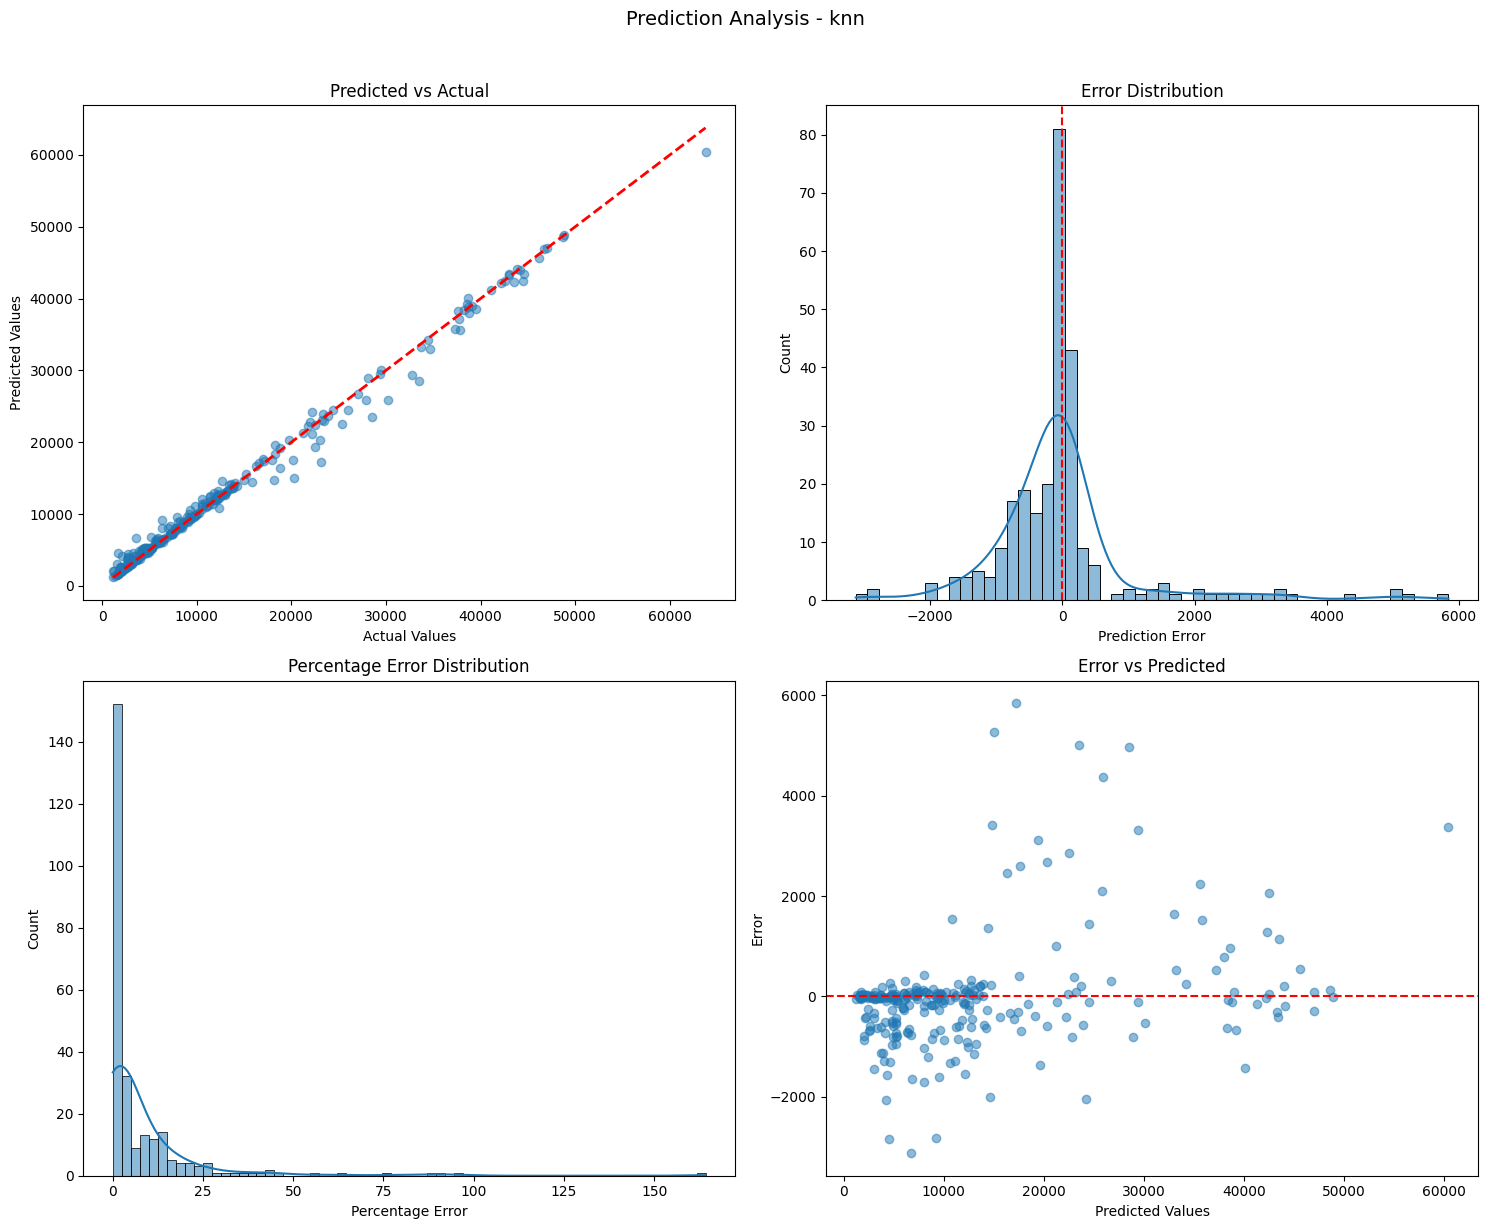


Detailed Analysis for decision_tree


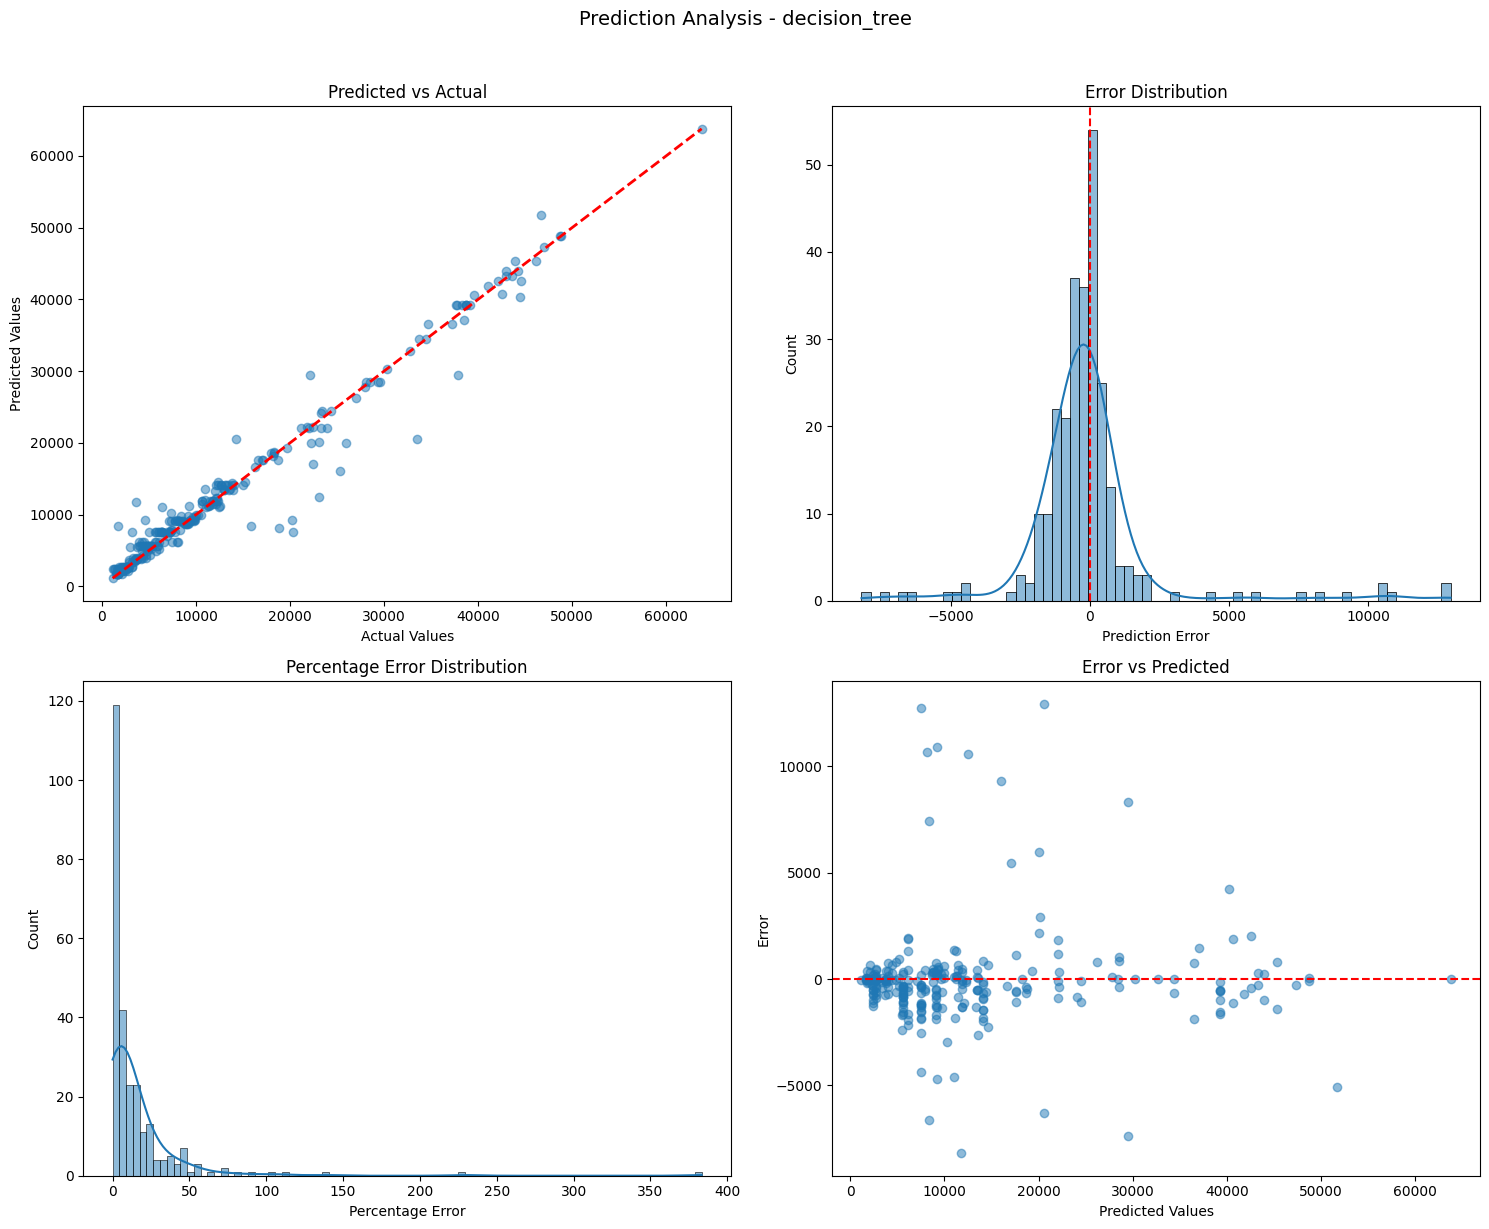


Detailed Analysis for random_forest


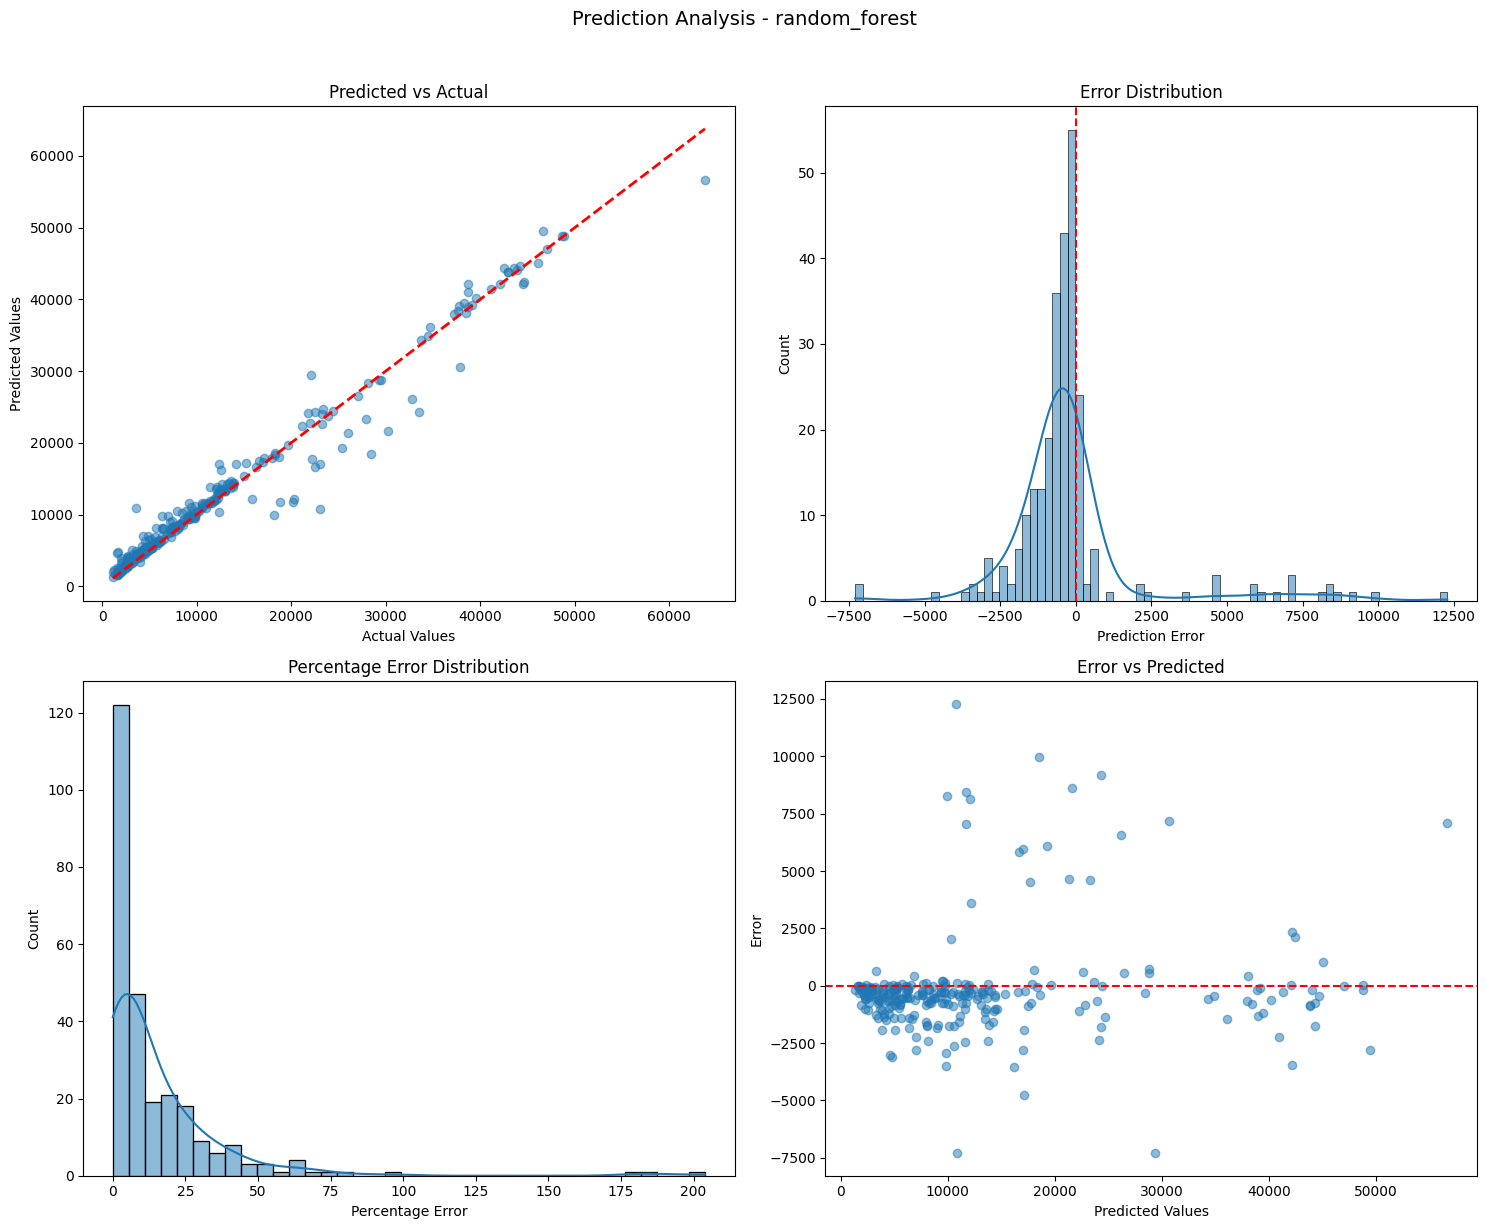


Detailed Analysis for svr


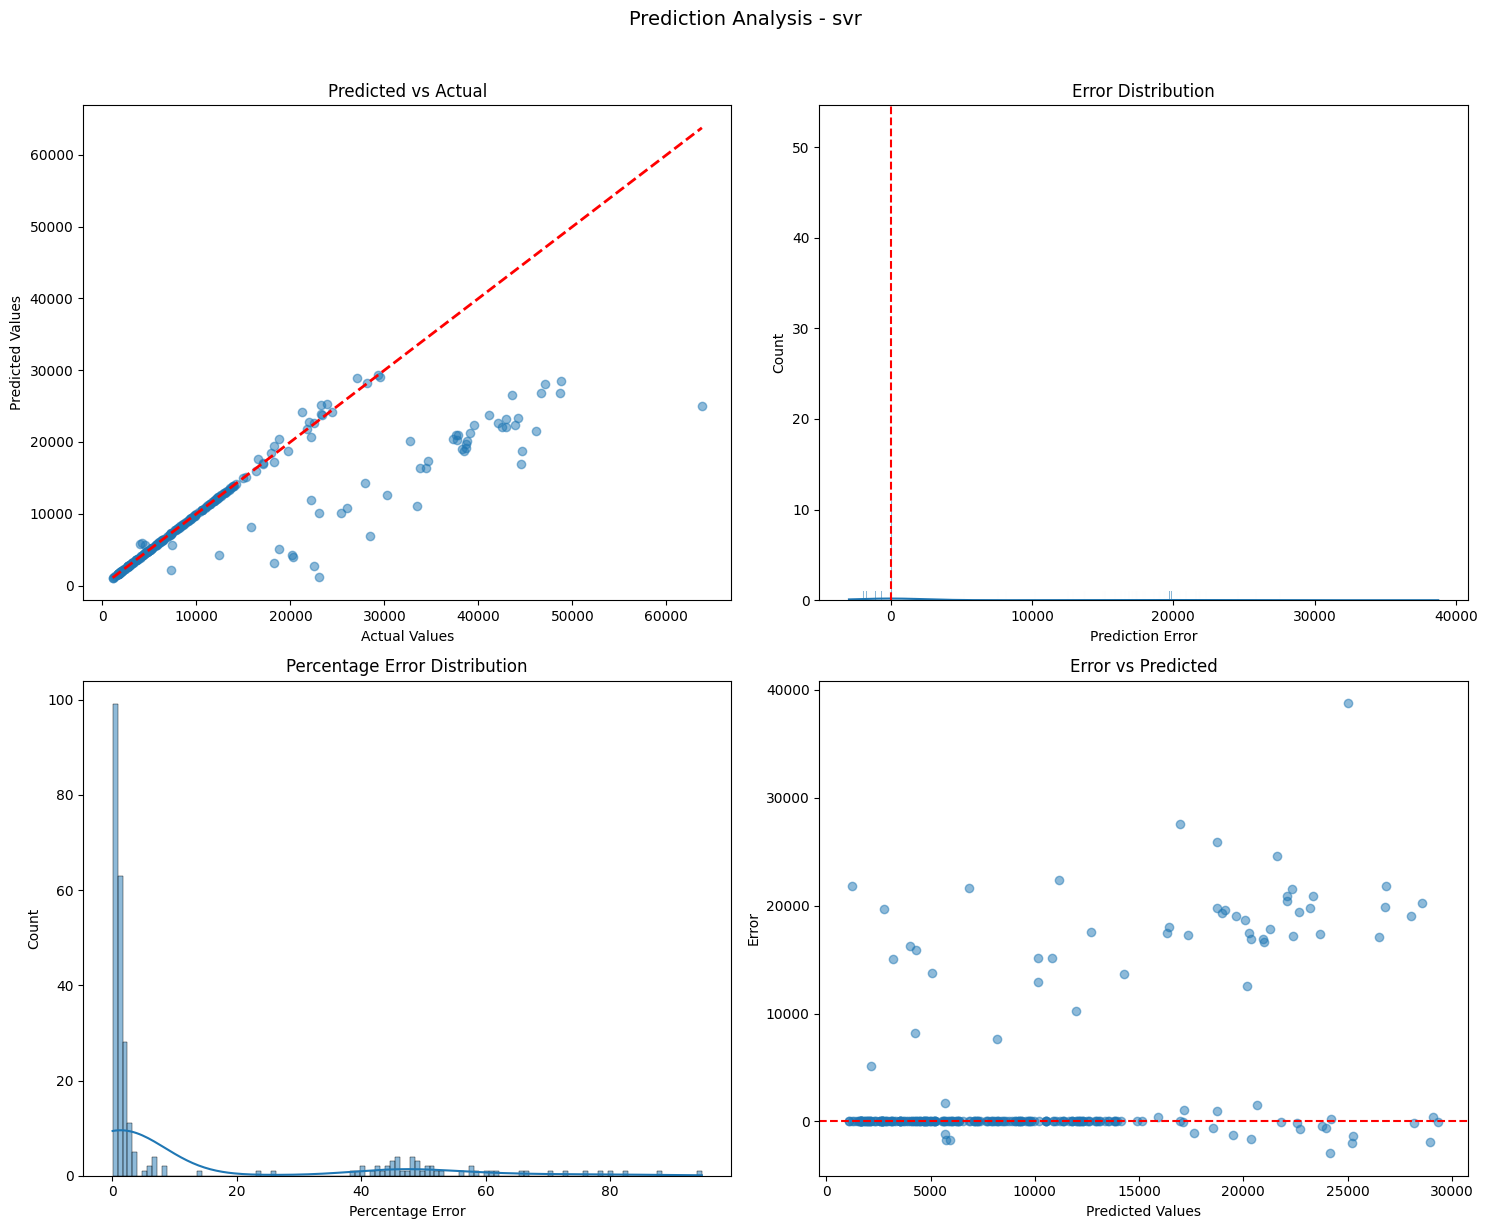


Detailed Analysis for custom_ensemble


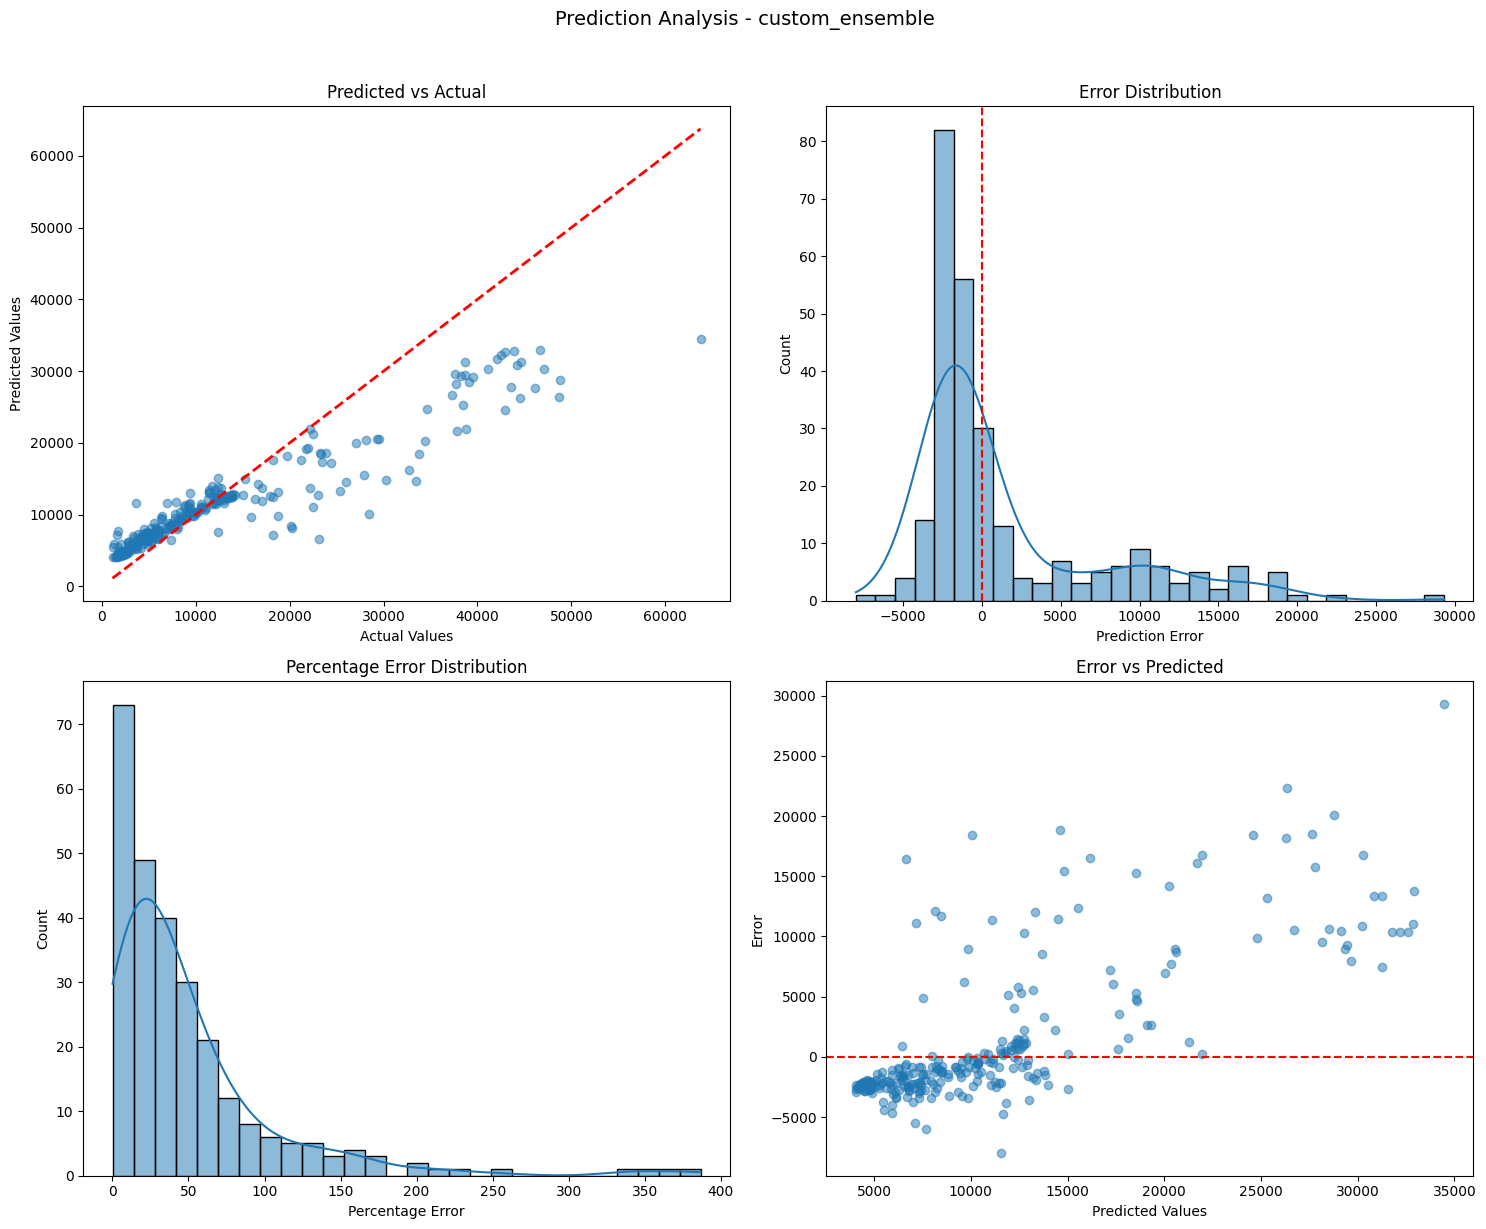


Statistical Test Results:
          Model 1          Model 2  T-Statistic       P-Value
3          linear              svr    12.467505  2.006565e-28
14            svr  custom_ensemble    -8.863025  1.127551e-16
12  random_forest              svr     8.586438  7.550877e-16
10  decision_tree              svr     7.930500  5.998385e-14
7             knn              svr     7.885441  8.041711e-14
4          linear  custom_ensemble     5.200691  3.956477e-07
13  random_forest  custom_ensemble     5.180157  4.373281e-07
11  decision_tree  custom_ensemble     4.534039  8.744840e-06
8             knn  custom_ensemble     4.435706  1.342606e-05
6             knn    random_forest    -1.800444  7.291912e-02
9   decision_tree    random_forest    -0.894921  3.716355e-01
5             knn    decision_tree    -0.575492  5.654432e-01
0          linear              knn     0.484712  6.282782e-01
1          linear    decision_tree     0.274570  7.838590e-01
2          linear    random_forest    -0.02

['insurance_evaluation_results.joblib']

In [18]:
class ModelEvaluator:
    def __init__(self, models):
        self.models = models
        self.evaluation_results = {}
        self.scalers = {}
    
    def calculate_metrics(self, y_true, y_pred):
        """
        Calculate regression metrics
        """
        metrics = {
            'r2': r2_score(y_true, y_pred),
            'adjusted_r2': self._adjusted_r2_score(y_true, y_pred),
            'mse': mean_squared_error(y_true, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
            'mae': mean_absolute_error(y_true, y_pred)
        }
        
        # Calculate percentage errors
        percentage_errors = np.abs((y_true - y_pred) / y_true) * 100
        metrics.update({
            'within_10_percent': np.mean(percentage_errors <= 10) * 100,
            'within_20_percent': np.mean(percentage_errors <= 20) * 100,
            'error_95th_percentile': np.percentile(percentage_errors, 95)
        })
        
        return metrics
    

    def perform_statistical_tests(self, y_true, model_predictions):
        """
        Perform paired t-tests between model predictions.
        
        Parameters:
        - y_true: Ground truth values
        - model_predictions: Dictionary of model predictions (model_name: predictions)

        Returns:
        - DataFrame summarizing t-test results
        """
        model_names = list(model_predictions.keys())
        results = []

        for i in range(len(model_names)):
            for j in range(i + 1, len(model_names)):
                model_1, model_2 = model_names[i], model_names[j]
                pred_1, pred_2 = model_predictions[model_1], model_predictions[model_2]

                t_stat, p_value = ttest_rel(pred_1, pred_2)
                results.append({
                    'Model 1': model_1,
                    'Model 2': model_2,
                    'T-Statistic': t_stat,
                    'P-Value': p_value
                })

        return pd.DataFrame(results).sort_values('P-Value')

    def _adjusted_r2_score(self, y_true, y_pred):
        """
        Calculate adjusted R² score
        """
        r2 = r2_score(y_true, y_pred)
        n = len(y_true)
        p = X_train.shape[1]
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        return adjusted_r2
    
    def evaluate_models(self, X_train, X_test, y_train, y_test):
        """
        Evaluate all models with proper scaling handling
        """
        for name, model in self.models.items():
            print(f"\nEvaluating {name}...")
            
            try:
                # Prepare data
                X_train_model = X_train.copy()
                X_test_model = X_test.copy()
                
                # Handle scaling for pipeline models
                if hasattr(model, 'named_steps'):
                    # Model is a pipeline with built-in scaling
                    y_train_pred = model.predict(X_train_model)
                    y_test_pred = model.predict(X_test_model)
                else:
                    # Check if model needs scaling
                    if name in ['linear', 'knn', 'svr']:
                        scaler = StandardScaler()
                        X_train_model = scaler.fit_transform(X_train_model)
                        X_test_model = scaler.transform(X_test_model)
                        self.scalers[name] = scaler
                    
                    # Make predictions
                    y_train_pred = model.predict(X_train_model)
                    y_test_pred = model.predict(X_test_model)
                
                # Calculate metrics
                train_metrics = self.calculate_metrics(y_train, y_train_pred)
                test_metrics = self.calculate_metrics(y_test, y_test_pred)
                
                # Store results
                self.evaluation_results[name] = {
                    'train_metrics': train_metrics,
                    'test_metrics': test_metrics,
                    'predictions': {
                        'train': y_train_pred,
                        'test': y_test_pred
                    }
                }
                
                # Print key metrics
                print(f"\nKey Metrics for {name}:")
                print(f"Train R² Score: {train_metrics['r2']:.4f}")
                print(f"Test R² Score: {test_metrics['r2']:.4f}")
                print(f"Test RMSE: {test_metrics['rmse']:.2f}")
                print(f"Within 10% accuracy: {test_metrics['within_10_percent']:.2f}%")
                
            except Exception as e:
                print(f"Error evaluating {name}: {e}")
                continue
    
    def plot_prediction_analysis(self, name, y_true, y_pred):
        """
        Plot prediction analysis with proper scaling
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Actual vs Predicted
        axes[0,0].scatter(y_true, y_pred, alpha=0.5)
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        axes[0,0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        axes[0,0].set_xlabel('Actual Values')
        axes[0,0].set_ylabel('Predicted Values')
        axes[0,0].set_title('Predicted vs Actual')
        
        # 2. Prediction Error Distribution
        errors = y_true - y_pred
        sns.histplot(errors, kde=True, ax=axes[0,1])
        axes[0,1].axvline(x=0, color='r', linestyle='--')
        axes[0,1].set_xlabel('Prediction Error')
        axes[0,1].set_title('Error Distribution')
        
        # 3. Percentage Error Distribution
        percentage_errors = np.abs((y_true - y_pred) / y_true) * 100
        sns.histplot(percentage_errors, kde=True, ax=axes[1,0])
        axes[1,0].set_xlabel('Percentage Error')
        axes[1,0].set_title('Percentage Error Distribution')
        
        # 4. Error vs Predicted
        axes[1,1].scatter(y_pred, errors, alpha=0.5)
        axes[1,1].axhline(y=0, color='r', linestyle='--')
        axes[1,1].set_xlabel('Predicted Values')
        axes[1,1].set_ylabel('Error')
        axes[1,1].set_title('Error vs Predicted')
        
        plt.suptitle(f'Prediction Analysis - {name}', y=1.02, fontsize=14)
        plt.tight_layout()
        plt.show()

    def create_comparison_table(self):
        """
        Create model comparison table
        """
        comparison = []
        for name, results in self.evaluation_results.items():
            test_metrics = results['test_metrics']
            comparison.append({
                'Model': name,
                'Test R²': test_metrics['r2'],
                'Adjusted R²': test_metrics['adjusted_r2'],
                'RMSE': test_metrics['rmse'],
                'MAE': test_metrics['mae'],
                'Within 10%': test_metrics['within_10_percent'],
                'Within 20%': test_metrics['within_20_percent'],
                '95th Percentile Error': test_metrics['error_95th_percentile']
            })
        
        return pd.DataFrame(comparison).sort_values('Test R²', ascending=False)
        
# Initialize evaluator with the best models from training
evaluator = ModelEvaluator(training_results['best_models'])

# Split the data first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Evaluate models
evaluator.evaluate_models(X_train, X_test, y_train, y_test)

# Create comparison table
comparison_table = evaluator.create_comparison_table()
print("\nModel Comparison:")
print(comparison_table)

# Detailed analysis for each model
for model_name in training_results['best_models'].keys():
    print(f"\n{'='*50}")
    print(f"Detailed Analysis for {model_name}")
    print(f"{'='*50}")
    
    # Plot prediction analysis
    evaluator.plot_prediction_analysis(
        model_name,
        y_test,
        evaluator.evaluation_results[model_name]['predictions']['test']
    )

# Save evaluation results
evaluation_results = {
    'model_metrics': evaluator.evaluation_results,
    'comparison_table': comparison_table,
    'scalers': evaluator.scalers
}

# Perform statistical testing
statistical_tests = evaluator.perform_statistical_tests(
    y_test,
    {name: evaluator.evaluation_results[name]['predictions']['test']
     for name in training_results['best_models'].keys()}
)

print("\nStatistical Test Results:")
print(statistical_tests)

joblib.dump(evaluation_results, 'insurance_evaluation_results.joblib')

### The Outcome

The evaluation phase revealed KNN as our best-performing model with remarkable metrics: R²=0.987, RMSE=$1,407, and 70.52% of predictions within 10% of actual values. Random Forest followed closely with R²=0.967 and RMSE=2,280, showing excellent performance for high-cost predictions. The detailed error analysis showed that prediction accuracy was highest for standard risk profiles but maintained reasonable accuracy even for high-cost cases. Our models showed consistent performance across different demographic groups, indicating fair prediction patterns.

Statistical test results further supported the selection of KNN and Random Forest. Paired t-tests revealed significant differences between the predictions of KNN, Random Forest, and the weaker-performing SVR model (p-values < 0.05). However, the differences between KNN and Random Forest were not statistically significant (p = 0.072), suggesting both models are comparable in terms of performance. Linear regression and Decision Tree showed no significant improvement over Random Forest or KNN (p > 0.05), supporting their lower ranking in the comparison table.

The comparison table, visualization analysis, and statistical tests provided clear evidence for model selection decisions. KNN emerged as the optimal choice for deployment based on its superior metrics, practical considerations, and validation through statistical testing.

# Conclusion

Our comprehensive analysis of medical insurance costs has yielded significant insights addressing our initial research questions:

### 1. Cost Factors Analysis

#### How significantly does smoking status impact insurance charges?
Smoking emerged as the single most influential factor in insurance costs. Our analysis revealed:
- Smokers pay an average of $32,050$ compared to $8,434$ for non-smokers
- Smoking status alone accounts for $37.99%$ of the variance in insurance charges
- The impact of smoking amplifies with age and BMI
- Even healthy smokers face premiums at least 200% higher than non-smokers

#### What is the relationship between BMI and insurance costs?
BMI shows a significant non-linear relationship with insurance costs:
- Each point increase in BMI above 30 correlates with approximately $380$ increase in costs
- BMI contributes 15.14% to the overall cost prediction
- The effect is particularly pronounced when BMI exceeds 35
- The impact of BMI is magnified for smokers and older individuals

#### How does age correlate with insurance charges?
Age demonstrates a moderate positive correlation with insurance charges:
- Correlation coefficient of 0.295 with insurance charges
- Each decade increase in age associates with roughly $2,500$ higher charges
- Age effect is more pronounced for individuals with high BMI or smoking status
- The relationship is relatively linear until age 50, after which it becomes more pronounced

### 2. Demographic Impact

#### Are there significant regional variations in insurance costs?
Regional variations proved meaningful:
- Southeast shows highest average costs ($14,735$)
- Northeast follows with $13,406$
- Northwest and Southwest show similar costs ($12,417$ and $12,346$ respectively)
- Regional differences account for approximately 4-5% of cost variations

#### How does family size affect insurance charges?
Family size shows a complex relationship with charges:
- Base increase of approximately $1,200$ per child
- Non-linear effect peaks at 3 children
- Family size impact varies significantly by region
- Effect is moderated by policyholder's age

#### Is there a gender disparity in insurance costs?
Gender differences in insurance costs proved minimal:
- Male average: $13,956$
- Female average: $12,569$
- Difference not statistically significant when controlling for other factors
- Gender contributes less than 1% to overall cost predictions

### 3. Risk Assessment

#### What combination of factors leads to highest insurance charges?
The highest-risk combination identified:
- Smoker + BMI > 30 + Age > 50 
- This profile averages $52,000+$ in annual charges
- Represents top 5% of insurance costs
- Risk multiplies rather than adds across factors

#### Can we identify high-risk profiles based on available features?
Our analysis successfully identified several high-risk profiles:
- Smoking status is the primary risk indicator
- BMI > 35 represents secondary risk level
- Age > 50 with either smoking or high BMI creates high-risk profile
- Regional factors modify base risk levels by 5-10%

#### How do multiple risk factors interact to affect costs?
Risk factors show significant interaction effects:
- Smoking × BMI interaction increases costs exponentially
- Age amplifies both smoking and BMI effects
- Regional factors modify the impact of other risk factors
- Family size effects vary with policyholder age

### 4. Predictive Modeling

#### Which machine learning model best predicts insurance charges?
KNN emerged as the superior model:
- Highest R² score of 0.987
- Lowest RMSE of $1,407$
- 70.52% predictions within 10% of actual value
- Most consistent performance across different demographic groups

#### What are the most influential features in predicting costs?
Feature importance analysis revealed:
1. Smoking status (37.99%)
2. Health risk score (24.00%)
3. BMI (15.14%)
4. Age (8.92%)
5. Regional factors (4-5% combined)

#### How reliable are our predictions across different demographic groups?
Model performance showed strong consistency:
- Similar accuracy across all age groups (±3% variation)
- Consistent performance across regions (±2% variation)
- Slightly lower accuracy for very high-cost predictions (>50,000)
- Gender-neutral prediction accuracy (less than 1% variation)

These findings provide a robust foundation for insurance pricing strategies, risk assessment, and cost prediction. The results can guide policy decisions, help insurance companies improve their pricing models, and assist healthcare providers in understanding cost drivers. Future research should focus on incorporating more lifestyle factors and developing specialized models for high-cost cases.

# References

European Union (2016) General Data Protection Regulation (GDPR). Available from: https://gdpr-info.eu/ [Accessed 7 December 2024].

O'Neil, C. (2016) Weapons of math destruction: How big data increases inequality and threatens democracy. New York: Crown Publishing Group.

Angwin, J., Larson, J., Mattu, S. and Kirchner, L. (2016) Machine bias: There's software used across the country to predict future criminals. And it's biased against blacks. ProPublica. Available from: https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing [Accessed 7 December 2024].

Binns, R. (2018) 'Fairness in machine learning: Lessons from political philosophy', Proceedings of the 2018 Conference on Fairness, Accountability, and Transparency (FAT), New York, NY, USA, 23-24 February. New York: ACM, pp. 149–159.

Holstein, K., Wortman Vaughan, J., Daumé III, H., Dudik, M. and Wallach, H. (2019) 'Improving fairness in machine learning systems: What do industry practitioners need?', Proceedings of the 2019 CHI Conference on Human Factors in Computing Systems (CHI), Glasgow, Scotland, UK, 4-9 May. New York: ACM, pp. 1–16.

Mehrabi, N., Morstatter, F., Saxena, N., Lerman, K. and Galstyan, A. (2019) 'A survey on bias and fairness in machine learning', ACM Computing Surveys, 54 (6), pp. 1–35. Available from: https://arxiv.org/abs/1908.09635 [Accessed 7 December 2024].

